# <center> On the use of VAEs for biomedical data integration <center> 

## Introduction
    
>In this project we will use MOVE (Multi-Omics Variational Autoencoder) to explore the power and potential pitfalls when using VAEs to perform multimodal data integration in biomedical settings.
>
>**We will cover:**
>
>- How the definition of the model's goal (loss) shapes its behavior.
>- Patterns in the organization of the samples in latent space and emerging dynamics under perturbations.
>- SHAP analyses to identify relevant features.
>- Using _In silico_ perturbations of the inputs to identify associations between features.
>
>We will finally show how all of these concepts can be applied to a real biomedical setting, namely the study of the microbial ecosystem changes in patients with Inflammatory Bowel Diseases (IBD).
>
>**Papers of interest:**
>    
>- Allesøe, R.L., Lundgaard, A.T., Hernández Medina, R. *et al*. Discovery of
>drug–omics associations in type 2 diabetes with generative deep-learning models.*Nat Biotechnol* (2023). https://www.nature.com/articles/s41587-022-01520-x
>- Diederik P Kingma, Max Welling. Auto-Encoding Variational Bayes. https://arxiv.org/abs/1312.6114
>- Lloyd-Price, J., Arze, C., Ananthakrishnan, A.N. et al. Multi-omics of the gut microbial ecosystem in inflammatory bowel diseases. Nature 569, 655–662 (2019). https://doi.org/10.1038/s41586-019-1237-9
>
>**About Variational AutoEncoders:**
>
>A Variational AutoEncoder (VAE) is a type of neural network aimed to compress the information stored in some inputs ($\vec{x}$) and reconstruct it as accurately as possible in an unsupervised manner {$\vec{x}'$}. A VAE consists in three parts: an encoder network, a decoder network, and a prior distribution that we set to be normal. The encoder will compress the input information and extract shared information between features.It is composed by the input layer, a vector of feature values for a given sample; hidden layers connecting the different features, and a latent layer. This latent layer will contain a compressed representation of our data (lower dimensionality feature vector). In VAEs, sample representations are not treated as data points, but rather distributions defined by a mean ($\mu$) and a standard deviation ($\sigma$) defined in a "latent space". However, once the model is trained we will use the mean vector as the sample's latent representation. The decoder will then reconstruct the input, recovering the high dimensional vector that constituted our sample. 
>
>**About MOVE:**
>
>MOVE was developed as a software to build VAEs that can take as input multimodal data, both in the form of continuous feature values and also discrete categories. Despite the framework's flexibility, when we talk about MOVE as a network we refer to a simple MLP-based VAE containing a single hidden layer with a non-linear activation. The framework allows us to study the latent space appearance and dynamics, but also to apply *in silico* perturbations to the input in order to find associations between features. These are measured as changes in the outputs, i.e. the reconstructed inputs. 

      

## Create a designated environment

We will first create an environment where we will store all the required packages, including MOVE. Make sure to run this notebook from said environment. 


In [ ]:
! conda create -n move_env python=3.9 --y

> _Note:_
>
> You might need to install ipykernel from the terminal to be able to run the cells in the notebook. You can do that as follows:
> ```
> pip install ipykernel
>```

**Installing MOVE:**

MOVE can be found online at RasmussenLab's Github repository (https://github.com/RasmussenLab/MOVE). It can be downloaded as a pip package from the command line as follows:
```bash
pip install move-dl
```

> ⚠️ **MOVE source code edits**
>
> A few edits to MOVE's code were made for this project. These can be found in the python notebook ```MOVE_edits.ipynb``` and can be summarized as follows:
>
> 1) **Removing feature_mask:**
>   When identifying associations (```identify_associations.py```) , feature_masks were removed and we only kept nan_masks.
>
> 2) **Corrected Cumulative distributions:**
> Cumulative distributions obtained when using the KS method were not properly normalized. We now multiply by bin_width to obtain a distribution between 0-1. The plot_cumulative function is found in ```dataset_distributions.py```
>
> 3) **Check categorical reconstructions after perturbations:**
> We noticed that categorical perturbations in the inputs induced tiny movements of the representations of the samples in latent space. Since samples did not abandon the cluster of origin, we suspected that the reconstructions would not recapitulate the perturbed state, but rather go back to the class of origin. To do that, we added a couple of lines to store the true targets and predicted targets for both baseline and perturbed inputs when identifying associations using the Bayes approach, and we now plot the categorical performance as the fraction of samples that were properly reconstructed.

In [ ]:
# MOVE can be installed as a pip package:
! pip install move-dl matplotlib_venn upsetplot biom-format wget

### Import required packages
The first step is to load the third party packages required to perform the different tasks in this notebook. To ease readability and improve clarity, specific ```move``` functions are imported when they need to be called.

In [ ]:
import argparse
import gzip
import json
# Main packages
import os
import random as rnd
from pathlib import Path

import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wget
from matplotlib import cm
from matplotlib_venn import venn2, venn3
from scipy.cluster.hierarchy import leaves_list, linkage
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from upsetplot import UpSet

# Reset all matplotlib settings to defaults
plt.rcdefaults()
plt.rcParams["font.family"] = "Times New Roman"

# Sythetic datasets benchmark

### Synthetic dataset creation

A synthetic dataset is created as a multivariate gaussian, where different features are different components or dimensions of the Gaussian and each sample is a draw from the distribution, i.e. $x \sim \mathcal{N}(\mu,\sigma)$. Explicit stronger correlations can be added by defining some features to be linear combinations of others. Categorical variables (binary) can be obtained by setting values below the mean to zero and values above to one for a given feature.

**Limitations:**

Given the way the dataset is constructed, associations lie in a spectrum (correlation coefficients span from 0 to 1). Adding strong and explicit relations between columns eases the classification between associated and non-associated pairs of features, as we can set a threshold below which we find no explicit correlations but only background correlations. In spite of this distinction in the nature of the correlations of the data, we can not fully consider background low correlations as negative examples of an association, since it is technically there but only fainter.

**Dataset creation functions:**

In [ ]:
def get_feature_names(settings):
    all_feature_names = [
        f"{key}_{i+1}"
        for key in settings.keys()
        for i in range(settings[key]["features"])
    ]
    return all_feature_names


def create_mean_profiles(settings):
    feature_means = []
    for key in settings.keys():
        mean = settings[key]["offset"]
        for freq, coef in zip(
            settings[key]["frequencies"], settings[key]["coefficients"]
        ):
            mean += coef * (
                np.sin(
                    freq * np.arange(settings[key]["features"]) + settings[key]["phase"]
                )
                + 1
            )
        feature_means.extend(list(mean))
    return feature_means


def create_ground_truth_correlations_file(correlations):
    sort_ids = np.argsort(abs(correlations), axis=None)[::-1]  # 1D: N x C
    corr = np.take(correlations, sort_ids)  # 1D: N x C
    sig_ids = sort_ids[abs(corr) > COR_THRES]
    sig_ids = np.vstack(
        (sig_ids // len(all_feature_names), sig_ids % len(all_feature_names))
    ).T
    associations = pd.DataFrame(sig_ids, columns=["feature_a_id", "feature_b_id"])
    a_df = pd.DataFrame(dict(feature_a_name=all_feature_names))
    a_df.index.name = "feature_a_id"
    a_df.reset_index(inplace=True)
    b_df = pd.DataFrame(dict(feature_b_name=all_feature_names))
    b_df.index.name = "feature_b_id"
    b_df.reset_index(inplace=True)
    associations = associations.merge(a_df, on="feature_a_id", how="left").merge(
        b_df, on="feature_b_id", how="left"
    )
    associations["Correlation"] = corr[abs(corr) > COR_THRES]
    associations = associations[
        associations.feature_a_id > associations.feature_b_id
    ]  # Only one half of the matrix
    return associations


def plot_score_matrix(
    array, feature_names, cmap="bwr", vmin=None, vmax=None, label_step=5
):
    if vmin is None:
        vmin = np.min(array)
    elif vmax is None:
        vmax = np.max(array)
    # if ax is None:
    fig = plt.figure(figsize=(3.5, 3.5))
    plt.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(
        np.arange(0, len(feature_names), label_step),
        feature_names[::label_step],
        fontsize=10,
        rotation=90,
    )
    plt.yticks(
        np.arange(0, len(feature_names), label_step),
        feature_names[::label_step],
        fontsize=10,
    )
    plt.tight_layout()
    # ax
    return fig


def plot_feature_profiles(dataset, feature_means):
    ## Plot profiles
    fig = plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(len(feature_means)), feature_means, lw=1, marker=".", markersize=0
    )
    for sample in dataset:
        plt.plot(
            np.arange(len(feature_means)), sample, lw=0.1, marker=".", markersize=0
        )
    plt.xlabel("Feature number")
    plt.ylabel("Count number")
    plt.title("Patient specific profiles")
    plt.tight_layout()

    return fig


def plot_feature_correlations(dataset, pairs_2_plot):
    fig = plt.figure()
    for f1, f2 in pairs_2_plot:
        plt.plot(
            dataset[:, f1],
            dataset[:, f2],
            lw=0,
            marker=".",
            markersize=1,
            label=f"{correlations[f1,f2]:.2f}",
        )
    plt.xlabel("Feature A")
    plt.ylabel("Feature B")
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        fancybox=True,
        shadow=True,
        ncol=5,
    )
    plt.title("Feature correlations")
    plt.tight_layout()

    return fig


def save_splitted_datasets(
    settings: dict, PROJECT_NAME, dataset, all_feature_names, n_samples, outpath
):
    # Save index file
    index = pd.DataFrame({"ID": list(np.arange(1, n_samples + 1))})
    index.to_csv(outpath / f"random.{PROJECT_NAME}.ids.txt", index=False, header=False)
    # Save continuous files
    df = pd.DataFrame(
        dataset, columns=all_feature_names, index=list(np.arange(1, n_samples + 1))
    )
    cum_feat = 0
    for key in settings.keys():
        df_feat = settings[key]["features"]
        df_cont = df.iloc[:, cum_feat : cum_feat + df_feat]
        df_cont.insert(0, "ID", np.arange(1, n_samples + 1))
        df_cont.to_csv(
            outpath / f"random.{PROJECT_NAME}.{key}.tsv", sep="\t", index=False
        )
        cum_feat += df_feat

**Create high dimensional sythetic dataset:**

In [ ]:
########################### Hyperparameters ####################################
PROJECT_NAME = "random_all_sim"
MODE = "linear"  # "non-linear"
HIGH_CORR = True  # Adding explicit correlations between columns
SEED_1 = 1  # 1234
np.random.seed(SEED_1)
rnd.seed(SEED_1)

COV_ALPHA = 0.99  # Covariance matrix sparsity
N_SAMPLES = 5000

SETTINGS = {
    "Continuous_A": {
        "features": 50,
        "frequencies": [0.002, 0.01, 0.02],
        "coefficients": [500, 100, 50],
        "phase": 0,
        "offset": 700,
    },
    "Continuous_B": {
        "features": 100,
        "frequencies": [0.001, 0.05, 0.08],
        "coefficients": [80, 20, 10],
        "phase": np.pi / 2,
        "offset": 300,
    },
    "Categorical_A": {
        "features": 1,
        "frequencies": [0.1, 0.5, 0.8],
        "coefficients": [0.2, 0.1, 0.05],
        "phase": np.pi / 2,
        "offset": 10,
    },
    "Categorical_B": {
        "features": 1,
        "frequencies": [0.01, 0.5, 0.08],
        "coefficients": [10, 0.1, 0.05],
        "phase": np.pi,
        "offset": 10,
    },
}

COR_THRES = 0.02
PAIRS_OF_INTEREST = [(1, 2), (3, 4)]  # ,(77,75),(99,70),(38,2),(67,62)]

# Path to store output files
outpath = Path("./synthetic_data/")
outpath.mkdir(exist_ok=True, parents=True)

################################## Main script ##################################

# Add all datasets in a single matrix:
all_feature_names = get_feature_names(SETTINGS)
feat_means = create_mean_profiles(SETTINGS)

# Covariance matrix definition
if MODE == "linear":
    covariance_matrix = make_sparse_spd_matrix(
        n_dim=len(all_feature_names),
        alpha=COV_ALPHA,
        smallest_coef=0,
        largest_coef=1,
        norm_diag=False,
        random_state=SEED_1,
    )
elif MODE == "non-linear":
    covariance_matrix = np.identity(len(all_feature_names))

ABS_MAX = np.max(abs(covariance_matrix))
fig = plot_score_matrix(
    covariance_matrix, all_feature_names, vmin=-ABS_MAX, vmax=ABS_MAX
)
fig.savefig(outpath / f"Covariance_matrix_{PROJECT_NAME}.svg")

# Create the dataset
dataset = np.random.multivariate_normal(feat_means, covariance_matrix, N_SAMPLES)

# Add non-linearities
if MODE == "non-linear":
    for i, j in PAIRS_OF_INTEREST:
        freq = np.random.choice([4, 5, 6])
        dataset[:, i] += np.sin(freq * dataset[:, j])

# No scaling in the dataset creation! It will be handled in the data preprocessing of the move pipeline.
scaled_dataset = dataset

if HIGH_CORR:  # The last half of the features are combinations of the first half:
    for i in range(scaled_dataset.shape[1] // 2):
        col_1 = np.random.choice(range(scaled_dataset.shape[1] // 2))
        col_2 = np.random.choice(range(scaled_dataset.shape[1] // 2))
        scaled_dataset[:, i + scaled_dataset.shape[1] // 2] = (
            scaled_dataset[:, col_1] + scaled_dataset[:, col_2]
        ) / 2 + np.random.normal()

# Binarize the categorical dataset
NUM_CAT = SETTINGS["Categorical_A"]["features"] + SETTINGS["Categorical_B"]["features"]
columns_to_binarize = scaled_dataset[:, -NUM_CAT:]

# Compute the mean of each of the categorical columns
means = columns_to_binarize.mean(axis=0)

# Apply the binarization
scaled_dataset[:, -NUM_CAT:] = (columns_to_binarize > means).astype(int)

# Visualize the actual correlations in the data
correlations = np.corrcoef(scaled_dataset, rowvar=False)
fig = plot_score_matrix(correlations, all_feature_names, vmin=-1, vmax=1, label_step=20)
fig.savefig(outpath / f"Correlations_{PROJECT_NAME}.svg", dpi=200)

# Sort correlations by absolute value
associations = create_ground_truth_correlations_file(correlations)
associations.to_csv(outpath / f"changes.{PROJECT_NAME}.txt", sep="\t", index=False)

# Plot feature profiles per sample
fig = plot_feature_profiles(scaled_dataset, feat_means)
fig.savefig(outpath / "Multi-omic_profiles.svg")

## Plot correlations
fig = plot_feature_correlations(dataset, PAIRS_OF_INTEREST)
fig.savefig(outpath / "Feature_correlations.svg")

fig = plot_feature_correlations(scaled_dataset, PAIRS_OF_INTEREST)
fig.savefig(outpath / "Feature_correlations_scaled.svg")

# Write tsv files with feature values for all samples in both datasets:
save_splitted_datasets(
    SETTINGS, PROJECT_NAME, scaled_dataset, all_feature_names, N_SAMPLES, outpath
)

## MOVE 

The MOVE pipeline consists in the following steps: 
1) **Encoding the data**
2) **Analyze latent space**
3) **Identify associations between features**
- Associations between a given categorical feature (e.g. Is the patient taking a drug? Yes / No) against the contiuous features.
- Associations between a given continuous feature vs. the rest of continuous features.

The following description of the different steps is mostly taken from the [NNFC workshop](https://github.com/RasmussenLab/MOVE/tree/nnfc-workshop), feel free to look at that as well!

### 1) Encode data

The first step in order to run MOVE is to encode the data in a format that the model can understand.

To encode the data we store all datasets in a TSV format. Each table needs to have a shape `N` &times; `M`, i.e. `N` rows and `M` columns where `N` is the number of samples/individuals and `M` is the number of features.

> 📡 **How is data encoded?**
>
> **_Categorical data is one-hot encoded._** _For a feature like drug status , which has discrete values/categories (e.g., yes or no), we encode these categories as_ binary bit flags. _This means each category is assigned a value starting with one, and then represented in binary format (with zeros and ones)._
>
>_A useful property of flags is that they do not have hierarchy; they are incompatible with "<" or ">" operators. So (in our example), yes would not be considered more or less important than no._
>
> **_Continuous data can be z-score normalized_**, _meaning that each feature can be rescaled to have zero mean and unit variance:_
>
>  $$ Z = \frac{x-\mu}{\sigma} $$
> Where $x$ is the vector of feature values for all samples, $\mu$ and $\sigma$ its mean and standard deviation, respectively.
> We can either transform the data beforehand or set the config flags for log2 transformation and scaling to True.


The first step is to read the configuration called `random_continuous_paper` and specify the pre-defined task called `encode_data`.

⚠️ Remember that the notebook takes user-defined configs in a `config/data` directory located in the current working directory.


### 2) Latent space analyses:

This section trains MOVE to integrate the data into a latent space. We will then plot the results and find the important variables for the integration using SHAP analysis.

> ℹ️ About SHAP analysis.
>
> There are many ways to identify the most important features in the data, or the set of features that the model will use the most when encoding the data into a compressed/latent representation. One of them is SHAP (SHapley Additive exPlanations) analysis.
>
> This method measures how much do samples move in latent space when removing one variable at a time from the input. If the model gives a lot of importance to an input variable, e.g. the concentration of a metabolite, removing it from the input will lead to a significant movement of the samples in latent space (i.e., wide band in the SHAP plots, impact on latent space). On the other hand, if an input variable is not really needed, the model will "ignore" it and hence the latent space representation of the samples will not change much when that feature is not there anymore (impact on latent space close to 0).



As in previous examples, first we need to read our configuration files and then we can run the `random_continuous_paper__latent` task. You can have a look at the file in ```config/task/random_continuous_paper__latent.yaml```.


>_📖 For the advanced reader:_ _This config file, in addition, explicitly sets the learning rate to be 1e-4 and introduces the factors beta (controlling how variational do we make the autoencoder) and the Kullback-Leibler divergence warmup steps, which will gradually introduce the loss term that pushes the samples towards the center of the latent space._


⚠️  If you get a similar error:

```
RuntimeError: Error(s) in loading state_dict for VAE:
size mismatch for encoderlayers.0.weight: copying a param with shape torch.Size([720, 1342]) from checkpoint, the shape in current model is torch.Size([900, 1342]).
```

Erase the model.pt file in the results folder, e.g. ```results_cont_paper/latent_space```

### 3) Identify associations between features: 

Lastly, we will use what the model has learnt to identify entangled or associated variables.

When perturbing the input value of a certain feature for all samples, the latent representation of said samples will change, and so will their reconstructions. We can track the induced shifts in output values to identify the features that were affected the most when perturbing the original feature, at a cohort level.

> ℹ️ We will use use the [Bayesian decision theory-based approach](https://www.nature.com/articles/s41587-022-01520-x#Sec15), presented in the Methods section of the original paper. We will also use an approach based on Kolmogorov-Smirnov distances between the feature reconstruction distributions, comparing them before and after perturbing an input feature.


MOVE can be run in a jupyter-notebook friendly manner by importing specific functions from the package as follows:

In [ ]:
### Running MOVE on synthetic data
from move.data import io
from move.tasks import analyze_latent, encode_data, identify_associations

# Configuration mapping
configs = {
    "encode": ("random_continuous_paper", "encode_data"),
    "latent": ("random_continuous_paper", "random_continuous_paper__latent"),
    "ttest": ("random_continuous_paper", "random_continuous_paper__id_assoc_ttest"),
    "bayes": ("random_continuous_paper", "random_continuous_paper__id_assoc_bayes"),
    "ks": ("random_continuous_paper", "random_continuous_paper__id_assoc_ks"),
}

# Read all configs at once
config_data = {name: io.read_config(*params) for name, params in configs.items()}

# Execute tasks
encode_data(config_data["encode"].data)
analyze_latent(config_data["latent"])

# Run all association identification methods
for method in ["ttest", "bayes", "ks"]:
    identify_associations(config_data[method])

Alternatively, move can be run using a command line style as follows. Please note that the folder structure must be such that move can find the config files.

```python
# Encode data
! move-dl task=encode_data data=random_continuous_paper 
# Identify assoc bayes
! move-dl task=random_continuous_paper__id_assoc_bayes data=random_continuous_paper
# Identify assoc KS
! move-dl task=random_continuous_paper__id_assoc_ks data=random_continuous_paper 
# Identify assoc t-test
! move-dl task=random_continuous_paper__id_assoc_ttest data=random_continuous_paper 
```

### Comparing methods to identify associations

We just run MOVE using the three methods to identify associations between features (t-test, Bayes and KS). The resulting tsv files can be compared with the ground truths file to benchmark their performance.

In [ ]:
# Create a colormap from seaborn
cmap = sns.color_palette("Dark2", 3, as_cmap=False)  # False for a list of colors

# Set the color cycle for matplotlib using the colormap
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cmap)


##################################### Functions #############################################
def plot_confusion_matrix(cm, target_names, cmap=None, normalize=False):
    """Function that plots the confusion matrix given cm."""

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    fig = plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0, fontsize=12)
        plt.yticks(tick_marks, target_names, fontsize=12)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14,
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14,
            )

    plt.tight_layout()
    plt.ylabel("True label", fontsize=14)
    plt.xlabel(
        "Predicted label\naccuracy={:0.4f}; misclass={:0.4f}".format(
            accuracy, misclass
        ),
        fontsize=14,
    )

    return fig


def classify_associations(target_file, assoc_tuples):
    self_assoc = 0  # Self associations
    found_assoc_dict = {}
    false_assoc_dict = {}
    tp_fp = np.array([[0, 0]])
    with open(target_file, "r") as f:
        for line in f:
            if line[0] != "f":
                splitline = line.strip().split("\t")
                feat_a = splitline[2]
                feat_b = splitline[3]
                score = abs(float(splitline[5]))
                if feat_a == feat_b:  # Self associations will not be counted
                    self_assoc += 1
                else:
                    if (feat_a, feat_b) in assoc_tuples:
                        found_assoc_dict[(feat_a, feat_b)] = score
                        if (
                            feat_b,
                            feat_a,
                        ) not in found_assoc_dict.keys():  # If we had not found it yet
                            tp_fp = np.vstack((tp_fp, tp_fp[-1] + [0, 1]))
                    elif (feat_a, feat_b) not in assoc_tuples:
                        false_assoc_dict[(feat_a, feat_b)] = score
                        if (feat_b, feat_a) not in false_assoc_dict.keys():
                            tp_fp = np.vstack((tp_fp, tp_fp[-1] + [1, 0]))

    # Remove duplicated associations:
    for i, j in list(found_assoc_dict.keys()):
        if (j, i) in found_assoc_dict.keys():
            del found_assoc_dict[
                (j, i)
            ]  # remove the weakest direction for the association

    for i, j in list(false_assoc_dict.keys()):
        if (j, i) in false_assoc_dict.keys():
            del false_assoc_dict[(i, j)]

    return self_assoc, found_assoc_dict, false_assoc_dict, tp_fp


def create_confusion_matrix(n_feat, associations, real_assoc, false_assoc):
    cm = np.empty((2, 2))
    # TN: only counting the upper half matrix (non doubled associations)
    cm[0, 0] = (n_feat * n_feat - n_feat) / 2 - (
        associations + false_assoc
    )  # Diagonal is discarded
    cm[0, 1] = false_assoc
    cm[1, 0] = associations - real_assoc
    cm[1, 1] = real_assoc

    return cm


def get_precision_recall(found_assoc_dict, false_assoc_dict, associations):
    y_true = []
    y_pred = []

    # True Positives
    for score in found_assoc_dict.values():
        y_true.append(1)
        y_pred.append(score)
    # False Positives
    for score in false_assoc_dict.values():
        y_true.append(0)
        y_pred.append(score)
    # False negatives
    for _ in range(associations - len(found_assoc_dict)):
        y_true.append(1)
        y_pred.append(0)

    precision, recall, thr = precision_recall_curve(
        y_true, y_pred
    )  # thr will tell us score values
    avg_prec = average_precision_score(y_true, y_pred)

    return precision, recall, thr, avg_prec


def plot_precision_recall(precision, recall, avg_prec, label, ax):
    ax.scatter(
        recall,
        precision,
        lw=0,
        marker=".",
        s=5,
        edgecolors="none",
        label=f"{label} - APS:{avg_prec:.2f}",
    )
    ax.legend()
    return ax


def plot_thr_recall(thr, recall, label, ax):
    ax.scatter(recall[:-1], thr, lw=0, marker=".", s=5, edgecolors="none", label=label)
    ax.legend()
    return ax


def plot_TP_vs_FP(tp_fp, label, ax):
    ax.scatter(tp_fp[:, 0], tp_fp[:, 1], s=2, label=label, edgecolors="none")
    ax.legend()
    return ax


def plot_filling_order(order_list, last_rank=None):

    if last_rank is None:
        last_rank = len(order_list)
    fig = plt.figure()
    order_img = np.zeros((np.max(order_list), len(order_list)))
    for i, element in enumerate(order_list):
        order_img[element - 1, i:] = 1

    plt.imshow(order_img[:last_rank, :], cmap="binary")
    plt.xlabel("Correct prediction number")
    plt.ylabel("Association ranking")
    plt.plot(np.arange(last_rank), np.arange(last_rank))
    return fig


def plot_effect_size_matching(
    assoc_tuples_dict, found_assoc_dict, label, ALGORITHM, ax
):

    ground_truth_effects = [
        assoc_tuples_dict[key] for key in list(found_assoc_dict.keys())
    ]
    predicted_effects = np.array(list(found_assoc_dict.values()))

    if ALGORITHM == "ttest":
        # Eq 15 on https://doi.org/10.1146/annurev-statistics-031017-100307
        predicted_effects = [-np.log10(p) if p != 0 else -1 for p in predicted_effects]
        predicted_effects[predicted_effects == -1] = np.max(
            predicted_effects
        )  # Change zeros for max likelihood, -1 as dummy value
        predicted_effects = np.array(predicted_effects)

    max, min = np.max(predicted_effects), np.min(predicted_effects)
    standarized_pred_effects = (predicted_effects - min) / (max - min)
    ax.scatter(
        ground_truth_effects,
        standarized_pred_effects,
        s=12,
        edgecolors="none",
        label=label,
    )
    ax.legend()
    return ax


def plot_venn_diagram(venn, ax, mode="all", scale="log"):
    sets = [set(venn[key][mode]) for key in list(venn.keys())]
    labels = (key for key in list(venn.keys()))

    if len(venn) == 2:
        venn2(sets, labels, ax=ax)
    elif len(venn) == 3:
        venn3(sets, labels, ax=ax)
    else:
        raise ValueError("Unsupported number of input files.")


def plot_upsetplot(venn, assoc_tuples):

    all_assoc = set(
        [
            association
            for ALGORITHM in venn.keys()
            for association in venn[ALGORITHM]["all"]
        ]
    )
    columns = ["ground truth"]
    columns.extend([ALGORITHM for ALGORITHM in list(venn.keys())])

    df = {}
    for association in all_assoc:
        df[association] = []

        if association in assoc_tuples:
            df[association].append("TP")
        else:
            df[association].append("FP")

        for ALGORITHM in list(venn.keys()):
            if association in venn[ALGORITHM]["all"]:
                df[association].append(1)
            else:
                df[association].append(0)

    df = pd.DataFrame.from_dict(df, orient="index", columns=columns)
    df = df.set_index([pd.Index(df[ALGORITHM] == 1) for ALGORITHM in list(venn.keys())])
    upset = UpSet(df, intersection_plot_elements=0, show_counts=True)

    upset.add_stacked_bars(
        by="ground truth",
        colors=cm.Pastel1,
        title="Count by ground truth value",
        elements=10,
    )

    return upset


###################################### Main code ################################################


def main(args_list):
    parser = argparse.ArgumentParser(
        description="Read two files with ground truth associations and predicted associations."
    )
    parser.add_argument(
        "-p",
        "--perturbed",
        metavar="pert",
        type=str,
        required=True,
        help="perturbed feature names",
    )
    parser.add_argument(
        "-n",
        "--features",
        metavar="feat",
        type=int,
        required=True,
        help="total number of features",
    )
    parser.add_argument(
        "-r",
        "--reference",
        metavar="ref",
        type=str,
        required=True,
        help="path to the ground truth associations file",
    )
    parser.add_argument(
        "-o",
        "--outpath",
        metavar="outpath",
        type=str,
        required=True,
        help="path where figures will be saved",
    )
    parser.add_argument(
        "-t",
        "--targets",
        metavar="tar",
        type=str,
        required=True,
        nargs="+",
        help="path to the predicted associations files",
    )

    args = parser.parse_args(args_list)

    # Defining main performance evaluation figures:
    fig_0, ax_0 = plt.subplots(figsize=(5, 5))
    fig_1, ax_1 = plt.subplots(figsize=(5, 5))
    fig_2, ax_2 = plt.subplots(figsize=(5, 5))
    fig_3, ax_3 = plt.subplots(figsize=(5, 5))

    assoc_tuples_dict = {}

    # Reading the file with the ground truth changes:
    with open(args.reference, "r") as f:
        for line in f:
            if line[0] != "f" and line[0] != "n":
                splitline = line.strip().split("\t")
                feat_a = splitline[2]
                feat_b = splitline[3]
                assoc_strength = abs(float(splitline[4]))
                # Only can detect associations with perturbed features
                if args.perturbed in feat_a or args.perturbed in feat_b:
                    assoc_tuples_dict[(feat_a, feat_b)] = assoc_strength
                    assoc_tuples_dict[(feat_b, feat_a)] = assoc_strength

    associations = int(len(assoc_tuples_dict) / 2)
    venn = {}

    # Count and save found associations
    for target_file in args.targets:
        ALGORITHM = target_file.split("/")[-1].split("_")[3][:-4]
        self_assoc, found_assoc_dict, false_assoc_dict, tp_fp = classify_associations(
            target_file, list(assoc_tuples_dict.keys())
        )
        real_assoc = len(found_assoc_dict)  # True predicted associations
        false_assoc = len(false_assoc_dict)  # False predicted associations
        total_assoc = real_assoc + false_assoc

        venn[ALGORITHM] = {}
        venn[ALGORITHM]["correct"] = list(found_assoc_dict.keys())
        venn[ALGORITHM]["all"] = list(found_assoc_dict.keys()) + list(
            false_assoc_dict.keys()
        )

        # Assess ranking of associations (they are doubled in assoc_tuples):
        order_list = [
            list(assoc_tuples_dict.keys()).index((feat_a, feat_b)) // 2
            for (feat_a, feat_b) in list(found_assoc_dict.keys())
        ]
        fig = plot_filling_order(order_list)
        fig.savefig(f"Order_image_{ALGORITHM}.png", dpi=200)

        ax_0 = plot_effect_size_matching(
            assoc_tuples_dict, found_assoc_dict, ALGORITHM, ALGORITHM, ax_0
        )

        # Plot confusion matrix:
        cm = create_confusion_matrix(
            args.features, associations, real_assoc, false_assoc
        )
        fig = plot_confusion_matrix(
            cm, ["No assoc", "Association"], cmap=None, normalize=False
        )

        fig.savefig(f"Confusion_matrix_{ALGORITHM}.png", dpi=100, bbox_inches="tight")

        # Plot precision-recall and TP-FP curves
        precision, recall, thr, avg_prec = get_precision_recall(
            found_assoc_dict, false_assoc_dict, associations
        )

        ax_1 = plot_precision_recall(precision, recall, avg_prec, ALGORITHM, ax_1)
        ax_2 = plot_TP_vs_FP(tp_fp, ALGORITHM, ax_2)
        ax_3 = plot_thr_recall(thr, recall, ALGORITHM, ax_3)

        # Write results:
        with open("Performance_evaluation_summary_results.txt", "a") as f:
            f.write(f" File:  {target_file}\n")
            f.write(
                f"Ground truth detectable associations (i.e. involving perturbed feature,{args.perturbed}):{associations}\n"
            )
            f.write(
                f"{total_assoc} unique associations found\n{self_assoc} self-associations were found before filtering\n{real_assoc} were real associations\n{false_assoc} were either false or below the significance threshold\n"
            )
            # print("Correct associations:\n", found_assoc_tuples, "\n")
            f.write(
                f"Sensitivity:{real_assoc}/{associations} = {real_assoc/associations}\n"
            )
            f.write(
                f"Precision:{real_assoc}/{total_assoc} = {(real_assoc)/total_assoc}\n"
            )
            f.write(f"Order list:{order_list}\n\n")
            f.write("______________________________________________________\n")

    # Edit figures: layout
    ax_0.set_xlabel("Real effect")
    ax_0.set_ylabel("Predicted effect")
    ax_0.set_ylim((-0.02, 1.02))
    ax_0.set_xlim((0, 1.02))
    ax_0.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=3,
        fancybox=True,
        shadow=True,
    )

    ax_1.set_xlabel("Recall")
    ax_1.set_ylabel("Precision")
    ax_1.legend()
    ax_1.set_ylim((0, 1.05))
    ax_1.set_xlim((0, 1.05))

    ax_2.set_xlabel("False Positives")
    ax_2.set_ylabel("True Positives")
    ax_2.set_aspect("auto")

    ax_3.set_ylabel("Threshold")
    ax_3.set_xlabel("Recall")

    # Save main figures:
    fig_0.savefig(args.outpath + "Effect_size_matchin.svg", dpi=200)
    fig_1.savefig(args.outpath + "Precision_recall.svg", dpi=200)
    fig_2.savefig(args.outpath + "TP_vs_FP.svg", dpi=200)
    fig_3.savefig(args.outpath + "thr_vs_recall.svg", dpi=200)

    # Plotting venn diagram:
    if len(venn) == 2 or len(venn) == 3:
        fig_v, ax_v = plt.subplots(figsize=(4, 4))
        ax_v = plot_venn_diagram(venn, ax_v, mode="correct")
        fig_v.savefig(args.outpath + "Venn_diagram.svg", dpi=200)

    # Plotting UpSet plot
    upset = plot_upsetplot(venn, list(assoc_tuples_dict.keys()))
    upset.plot()
    plt.savefig(args.outpath + "UpSet.svg", dpi=200)

In [ ]:
args_list = [
    "-p",
    "Continuous_A_2",
    "-n",
    "36",
    "-r",
    "./synthetic_data/changes.random_all_sim.txt",
    "-o",
    "./synthetic_data/",
    "-t",
    "./results_cont_paper/identify_associations/results_sig_assoc_ttest.tsv",
    "./results_cont_paper/identify_associations/results_sig_assoc_bayes.tsv",
    "./results_cont_paper/identify_associations/results_sig_assoc_ks.tsv",
]

main(args_list)

**Comparing Bayes and KS score distributions:**

In [ ]:
df_bayes = pd.read_csv(
    "./results_cont_paper/identify_associations/results_sig_assoc_bayes.tsv", sep="\t"
)
df_ks = pd.read_csv(
    "./results_cont_paper/identify_associations/results_sig_assoc_ks.tsv", sep="\t"
)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot histograms using ax.hist() instead of np.histogram()
axs[0].hist(abs(df_bayes["bayes_k"]), bins=80)
axs[1].hist(abs(df_ks["ks_distance"]), bins=80)

# Add labels and titles
axs[0].set_title("Bayes K Distribution")
axs[0].set_xlabel("|Bayes K|")
axs[0].set_ylabel("Frequency")

axs[1].set_title("KS Distance Distribution")
axs[1].set_xlabel("|KS Distance|")
axs[1].set_ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig("./results_cont_paper/identify_associations/KS_vs_Bayes.svg", dpi=200)

df_bayes

**Synthetic data 2:**


Here we will create a simplified version of the datasets in order to:
-  explore the behavior of MOVE at high and low sample regimes (Low N: 50 / High N: 1000).
-  visualize the latent representations in a 3D latent space and their movement after the perturbations.


In [ ]:
! rm -r synthetic_data_II/
! rm -r results_cont_paper_II/
! rm -r results_cont_paper_II_high_N/
! rm -r results_cont_paper_II_low_N/
! rm -r interim_data_cont_paper_II/
! rm -r interim_data_cont_paper_II_high_N/
! rm -r interim_data_cont_paper_II_low_N/

In [ ]:
########################### Hyperparameters ####################################
PROJECT_NAME = "random_all_sim"
MODE = "linear"  # "non-linear"
SEED_1 = 123  # 1234
np.random.seed(SEED_1)
rnd.seed(SEED_1)

COV_ALPHA = 0.97

data_regimes_dict = {
    "synthetic_data_II": {
        "N_SAMPLES": 1000,
        "HIGH_CORR": True,
        "interim_path": "interim_data_cont_paper_II",
        "results_path": "results_cont_paper_II",
    },  # high N, added explicit corr
    "low_N_gaussian_corr": {
        "N_SAMPLES": 50,
        "HIGH_CORR": False,
        "interim_path": "interim_data_cont_paper_II_low_N",
        "results_path": "results_cont_paper_II_low_N",
    },
    "high_N_gaussian_corr": {
        "N_SAMPLES": 1000,
        "HIGH_CORR": False,
        "interim_path": "interim_data_cont_paper_II_high_N",
        "results_path": "results_cont_paper_II_high_N",
    },
}

SETTINGS = {
    "Continuous_A": {
        "features": 10,
        "frequencies": [0.002, 0.01, 0.02],
        "coefficients": [500, 100, 50],
        "phase": 0,
        "offset": 500,
    },
    "Continuous_B": {
        "features": 10,
        "frequencies": [0.001, 0.05, 0.08],
        "coefficients": [80, 20, 10],
        "phase": np.pi / 2,
        "offset": 400,
    },
    "Categorical_A": {
        "features": 1,
        "frequencies": [0.1, 0.5, 0.8],
        "coefficients": [0.2, 0.1, 0.05],
        "phase": np.pi / 2,
        "offset": 10,
    },
    "Categorical_B": {
        "features": 1,
        "frequencies": [0.01, 0.5, 0.08],
        "coefficients": [10, 0.1, 0.05],
        "phase": np.pi,
        "offset": 1,
    },
}

for path, hyperparams in data_regimes_dict.items():

    COR_THRES = 0.02
    PAIRS_OF_INTEREST = [(1, 2), (3, 4)]
    HIGH_CORR = hyperparams["HIGH_CORR"]
    N_SAMPLES = hyperparams["N_SAMPLES"]

    # Path to store output files
    outpath = Path(f"{path}")
    outpath.mkdir(exist_ok=True, parents=True)

    # %%
    # Add all datasets in a single matrix:
    all_feature_names = get_feature_names(SETTINGS)
    feat_means = create_mean_profiles(SETTINGS)

    # %%
    ###### Covariance matrix definition ######
    if MODE == "linear":
        covariance_matrix = make_sparse_spd_matrix(
            n_dim=len(all_feature_names),
            alpha=COV_ALPHA,
            smallest_coef=0,
            largest_coef=1,
            norm_diag=True,
            random_state=SEED_1,
        )
    elif MODE == "non-linear":
        covariance_matrix = np.identity(len(all_feature_names))

    ABS_MAX = np.max(abs(covariance_matrix))
    fig = plot_score_matrix(
        covariance_matrix, all_feature_names, vmin=-ABS_MAX, vmax=ABS_MAX
    )
    fig.savefig(outpath / f"Covariance_matrix_{PROJECT_NAME}.svg")

    # Create the dataset
    dataset = np.random.multivariate_normal(feat_means, covariance_matrix, N_SAMPLES)

    # Add non-linearities
    if MODE == "non-linear":
        for i, j in PAIRS_OF_INTEREST:
            freq = np.random.choice([4, 5, 6])
            dataset[:, i] += np.sin(freq * dataset[:, j])

    # scaled_dataset, _ = scale(dataset)
    # No scaling in the dataset creation! It will be handled in preprocessing.
    scaled_dataset = dataset

    if HIGH_CORR:  # The last half of the features are combinations of the first half:
        for i in range(scaled_dataset.shape[1] // 2):
            col_1 = np.random.choice(range(scaled_dataset.shape[1] // 2))
            col_2 = np.random.choice(range(scaled_dataset.shape[1] // 2))
            scaled_dataset[:, i + scaled_dataset.shape[1] // 2] = (
                scaled_dataset[:, col_1] + scaled_dataset[:, col_2]
            ) / 2 + np.random.normal()

    # Binarize the categorical dataset
    NUM_CAT = (
        SETTINGS["Categorical_A"]["features"] + SETTINGS["Categorical_B"]["features"]
    )
    columns_to_binarize = scaled_dataset[:, -NUM_CAT:]

    # Compute the mean of each of the categorical columns
    means = columns_to_binarize.mean(axis=0)

    # Apply the binarization
    scaled_dataset[:, -NUM_CAT:] = (columns_to_binarize > means).astype(int)

    # Correlations
    correlations = np.corrcoef(scaled_dataset, rowvar=False)
    fig = plot_score_matrix(
        correlations, all_feature_names, vmin=-1, vmax=1, label_step=5
    )
    fig.savefig(outpath / f"Correlations_{PROJECT_NAME}.svg", dpi=200)

    # Sort correlations by absolute value
    associations = create_ground_truth_correlations_file(correlations)
    associations.to_csv(outpath / f"changes.{PROJECT_NAME}.txt", sep="\t", index=False)

    # Plot feature profiles per sample
    fig = plot_feature_profiles(scaled_dataset, feat_means)
    fig.savefig(outpath / "Multi-omic_profiles.svg")

    ## Plot correlations
    fig = plot_feature_correlations(dataset, PAIRS_OF_INTEREST)
    fig.savefig(outpath / "Feature_correlations.svg")

    fig = plot_feature_correlations(scaled_dataset, PAIRS_OF_INTEREST)
    fig.savefig(outpath / "Feature_correlations_scaled.svg")

    # Write tsv files with feature values for all samples in both datasets:
    save_splitted_datasets(
        SETTINGS, PROJECT_NAME, scaled_dataset, all_feature_names, N_SAMPLES, outpath
    )

In [ ]:
### Running MOVE on simple synthetic data (command line style)
data_regimes_dict = {
    "synthetic_data_II": {
        "N_SAMPLES": 1000,
        "HIGH_CORR": True,
        "interim_path": "interim_data_cont_paper_II",
        "results_path": "results_cont_paper_II",
    },  # high N, added explicit corr
    "low_N_gaussian_corr": {
        "N_SAMPLES": 50,
        "HIGH_CORR": False,
        "interim_path": "interim_data_cont_paper_II_low_N",
        "results_path": "results_cont_paper_II_low_N",
    },
    "high_N_gaussian_corr": {
        "N_SAMPLES": 1000,
        "HIGH_CORR": False,
        "interim_path": "interim_data_cont_paper_II_high_N",
        "results_path": "results_cont_paper_II_high_N",
    },
}

for data_regime, hyperparams in data_regimes_dict.items():

    # Encode data
    ! move-dl task=encode_data data=random_continuous_paper_II data.raw_data_path={data_regime} data.interim_data_path={hyperparams["interim_path"]}  data.results_path={hyperparams["results_path"]}     # where result files will be placed

    # Analyze latent
    ! move-dl task=random_continuous_paper_II__latent data=random_continuous_paper_II data.raw_data_path={data_regime} data.interim_data_path={hyperparams["interim_path"]}  data.results_path={hyperparams["results_path"]}

    # Copy model trained on analyze latent to id_assoc directory
    ! mkdir -p {hyperparams["interim_path"]}/models
    ! mv {hyperparams["results_path"]}/latent_space/model.pt {hyperparams["interim_path"]}/models/model_3_0.pt

    # Identify assoc ks
    ! move-dl task=random_continuous_paper_II__id_assoc_ks data=random_continuous_paper_II data.raw_data_path={data_regime} data.interim_data_path={hyperparams["interim_path"]}  data.results_path={hyperparams["results_path"]}

**Plot reconstruction metrics separately:**

In [ ]:
# Plot categorical box-plots separately
plt.style.use("ggplot")

plt.rcParams.update(
    {
        "font.family": "Times New Roman",
        "font.size": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
    }
)

folders = [
    "results_cont_paper_II",
    "results_cont_paper_II_high_N",
    "results_cont_paper_II_low_N",
]
dfs = [
    pd.read_csv(f"{folder}/latent_space/reconstruction_metrics.tsv", sep="\t")
    for folder in folders
]

for i, df in enumerate(dfs):
    fig = plt.figure(figsize=(7, 5))

    # Scatter points for categorical data
    plt.scatter(
        [
            df["random.random_all_sim.Categorical_A"].mean(),
            df["random.random_all_sim.Categorical_B"].mean(),
        ],
        [0.8, 0.6],
        marker="d",
        s=128,
        color="#3e4297",
    )

    # Horizontal boxplots for continuous data
    bp = plt.boxplot(
        [
            df["random.random_all_sim.Continuous_A"],
            df["random.random_all_sim.Continuous_B"],
        ],
        positions=[0.4, 0.2],
        vert=False,
        widths=0.10,
        patch_artist=True,
        medianprops=dict(color="black"),
    )

    bp["boxes"][0].set_facecolor("#980000")
    bp["boxes"][1].set_facecolor("#980000")

    plt.xlim(-0.05, 1.05)
    plt.ylim(0.05, 0.95)
    plt.yticks(
        [0.8, 0.6, 0.4, 0.2],
        ["Categorical_A", "Categorical_B", "Continuous_A", "Continuous_B"],
        size=14,
    )
    plt.xticks(size=14)
    plt.xlabel("Score", size=16)
    plt.tight_layout()
    fig.savefig(
        f"./{folders[i]}/latent_space/Categorical_reconstructions_{i}.svg", dpi=200
    )

**Boosting continuous importance:**

Here we will train MOVE by setting a high weight (w=10) on the loss associated to the continuous datasets.

In [ ]:
hyperparams = {
    "N_SAMPLES": 1000,
    "HIGH_CORR": True,
    "data_path": "synthetic_data_II",
    "interim_path": "interim_data_cont_paper_II_10x_cont",
    "results_path": "results_cont_paper_II_10x_cont",
    "w": 10,
}

! move-dl task=encode_data data=random_continuous_paper_II data.raw_data_path={hyperparams["data_path"]} data.interim_data_path={hyperparams["interim_path"]}  data.results_path={hyperparams["results_path"]} +data.continuous_inputs.0.weight={hyperparams["w"]} +data.continuous_inputs.1.weight={hyperparams["w"]}
! move-dl task=random_continuous_paper_II__latent data=random_continuous_paper_II data.raw_data_path={hyperparams["data_path"]} data.interim_data_path={hyperparams["interim_path"]}  data.results_path={hyperparams["results_path"]} +data.continuous_inputs.0.weight={hyperparams["w"]} +data.continuous_inputs.1.weight={hyperparams["w"]}
# Copy model trained on analyze latent to id_assoc directory
! mkdir -p {hyperparams["interim_path"]}/models
! mv {hyperparams["results_path"]}/latent_space/model.pt {hyperparams["interim_path"]}/models/model_3_0.pt
! move-dl task=random_continuous_paper_II__id_assoc_ks data=random_continuous_paper_II data.raw_data_path={hyperparams["data_path"]} data.interim_data_path={hyperparams["interim_path"]}  data.results_path={hyperparams["results_path"]} +data.continuous_inputs.0.weight={hyperparams["w"]} +data.continuous_inputs.1.weight={hyperparams["w"]}

### 3D Latent space.

We will now represent the simplified dataset in a 3D latent space. This will allow us to immediately and intuitively understand the emerging behavior of MOVE given its architecture and loss function. We will also be able to check how the perturbations impact the latent location of the samples.

In [ ]:
plt.style.use("classic")
plt.rcParams.update(
    {
        "font.family": "Times New Roman",
        "font.size": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
    }
)

DATASET = "Continuous_B"  # "Continuous_A"
feature_list = pd.read_csv(
    f"./interim_data_cont_paper_II/random.random_all_sim.{DATASET}.txt", header=None
)
feature_list = feature_list.values.flatten()

figure_path = Path("./synthetic_data_II/figures_synthetic_small/")
! mkdir -p {figure_path}

latent_space = np.load(
    "./results_cont_paper_II/identify_associations/latent_location.npy"
)


def plot_3D_latent_and_displacement(
    mu_baseline,
    mu_perturbed,
    feature_values,
    feature_name,
    show_baseline=True,
    show_perturbed=True,
    show_arrows=True,
    step: int = 1,
    altitude: int = 30,
    azimuth: int = 45,
):
    """
    Plot the movement of the samples in the 3D latent space after perturbing one
    input variable.

    Args:
        mu_baseline:
            ND array with dimensions n_samples x n_latent_nodes containing
            the latent representation of each sample
        mu_perturbed:
            ND array with dimensions n_samples x n_latent_nodes containing
            the latent representation of each sample after perturbing the input
        feature_values:
            1D array with feature values to map to a colormap ("bwr"). Each sample is
            colored according to its value for the feature of interest.
        feature_name:
            name of the feature mapped to a colormap
        show_baseline:
            plot orginal location of the samples in the latent space
        show_perturbed:
            plot final location (after perturbation) of the samples in latent space
        show_arrows:
            plot arrows from original to final location of each sample
        angle:
            elevation from dim1-dim2 plane for the visualization of latent space.

    Raises:
        ValueError: If latent space is not 3-dimensional (3 hidden nodes).
    Returns:
        Figure
    """
    # construct cmap
    my_cmap = sns.color_palette("RdYlBu", as_cmap=True)

    eps = 1e-16
    if [np.shape(mu_baseline)[1], np.shape(mu_perturbed)[1]] != [3, 3]:
        raise ValueError(
            " The latent space must be 3-dimensional. Redefine num_latent to 3."
        )

    fig = plt.figure(layout="constrained", figsize=(5, 5))
    ax = fig.add_subplot(projection="3d")
    ax.view_init(altitude, azimuth)

    if show_baseline:
        vmin, vmax = np.min(feature_values[::step]), np.max(feature_values[::step])
        abs_max = np.max([abs(vmin), abs(vmax)])
        plot = ax.scatter(
            mu_baseline[::step, 0],
            mu_baseline[::step, 1],
            mu_baseline[::step, 2],
            marker="o",
            c=feature_values[::step],
            s=10,
            lw=0,
            cmap=my_cmap,
        )
        fig.colorbar(plot)

    if show_perturbed:
        ax.scatter(
            mu_perturbed[::step, 0],
            mu_perturbed[::step, 1],
            mu_perturbed[::step, 2],
            marker="o",
            c=feature_values[::step],
            s=10,
            label="perturbed",
            lw=0,
        )
    if show_arrows:
        u = mu_perturbed[::step, 0] - mu_baseline[::step, 0]
        v = mu_perturbed[::step, 1] - mu_baseline[::step, 1]
        w = mu_perturbed[::step, 2] - mu_baseline[::step, 2]

        module = np.sqrt(u * u + v * v + w * w)
        mask = module > eps
        max_u, max_v, max_w = np.max(abs(u)), np.max(abs(v)), np.max(abs(w))

        # Arrow colors will be weighted contributions of red -> dim1, green -> dim2, and blue-> dim3. I.e. purple arrow means movement in dims 1 and 3
        colors = [
            (abs(du) / max_u, abs(dv) / max_v, abs(dw) / max_w, 0.7)
            for du, dv, dw in zip(u, v, w)
        ]
        ax.quiver(
            mu_baseline[::step, 0][mask],
            mu_baseline[::step, 1][mask],
            mu_baseline[::step, 2][mask],
            u[mask],
            v[mask],
            w[mask],
            color=colors,
            lw=0.6,
        )

    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_zlabel("Dim 3")

    return fig


# Main code:
for i, feature in enumerate(feature_list):
    print(i)
    feature_values = np.load(
        f"./interim_data_cont_paper_II/random.random_all_sim.{DATASET}.npy"
    )
    CONDITION = "Categorical" in DATASET
    if CONDITION:
        feature_values = np.argmax(feature_values, axis=2)[:, i]
    else:
        feature_values = feature_values[:, i]

    print(feature_values)
    latent_space_baseline = latent_space[:, :, -1]
    latent_space_perturbed = latent_space[:, :, i]

    # # Plot latent space:
    n_pictures = 10
    PLOT = [0] if CONDITION else [0, 2, 3, 9]  # Plot Categorical A1
    if i in PLOT:
        print(i)
        # for pic_num, (azimuth, altitude) in enumerate(zip(
        #    np.linspace(90, 180, n_pictures), np.linspace(35, 55, n_pictures)
        # )):

        for pic_num, (azimuth, altitude) in enumerate([[120, 44]]):
            print(pic_num, azimuth, altitude)
            title = feature
            fig = plot_3D_latent_and_displacement(
                latent_space_baseline,
                latent_space_perturbed,
                feature_values=feature_values,
                feature_name=f"{title}",
                show_baseline=True,
                show_perturbed=False,
                show_arrows=False,
                altitude=altitude,
                azimuth=azimuth,
            )
            fig.savefig(figure_path / f"3D_latent_{pic_num}_perturbed_{feature}.svg")
            plt.close(fig)

            fig = plot_3D_latent_and_displacement(
                latent_space_baseline,
                latent_space_perturbed,
                feature_values=feature_values,
                feature_name=f"{title}",
                show_baseline=False,
                show_perturbed=False,
                show_arrows=True,
                altitude=altitude,
                azimuth=azimuth,
            )
            fig.savefig(
                figure_path / f"3D_latent_{pic_num}_perturbed_{feature}_arrows_max.svg"
            )
            plt.close(fig)

## Real world applications: 
### A) A Parkinsons dataset

Download the csv file The original table is provided as a Supplementary Dataset in the original article: [Parkinsons disease dataset](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-017-00047-5/MediaObjects/41598_2017_47_MOESM3_ESM.xls) by clicking on the link. 

In [ ]:
# Load the data
output_path = Path("./parkinsons_data/")
output_path.mkdir(exist_ok=True)
df = pd.read_csv(output_path / "dataset.csv", sep=",")

# Setting the index
df["ID"] = pd.RangeIndex(1, len(df) + 1)
df = df.set_index("ID")


# Function to convert columns to proper data types and handle missing values
def process_dataframe(dataframe, clean_medications=False):
    """Convert numerical columns to proper types and replace missing values with 'NA'"""
    processed_df = dataframe.copy()

    for col in processed_df.columns:
        # Skip columns that are categorical
        if col in [
            " Gender ",
            " Positive  history  of  Parkinson  disease  in  family ",
            " Antidepressant  therapy ",
            " Antiparkinsonian  medication ",
            " Antipsychotic  medication ",
            " Benzodiazepine  medication ",
        ]:
            # For categorical columns, just replace empty strings and various missing indicators
            processed_df[col] = processed_df[col].replace(
                ["", " ", "nan", "NaN", np.nan, None], "NA"
            )

            if clean_medications and "therapy" in col or "medication" in col:
                # Clean medication columns to keep only Yes/No
                processed_df[col] = processed_df[col].astype(str).str.strip()
                processed_df[col] = processed_df[col].apply(
                    lambda x: (
                        "Yes"
                        if x.startswith("Yes") or x.startswith(" Yes")
                        else "No" if x.startswith("No") or x.startswith(" No") else "NA"
                    )
                )
            else:
                # For other categorical columns, just replace empty strings and various missing indicators
                processed_df[col] = processed_df[col].replace(
                    ["", " ", "nan", "NaN", np.nan, None], "NA"
                )
        else:
            # For numerical columns, convert to numeric and handle missing values
            # First, replace various missing value indicators with NaN
            processed_df[col] = processed_df[col].replace(
                ["", " ", "-", "nan", "NaN"], np.nan
            )

            # Convert to numeric, coercing errors to NaN
            processed_df[col] = pd.to_numeric(processed_df[col], errors="coerce")

            # Replace NaN with 'NA' string for output
            processed_df[col] = processed_df[col].fillna("NA")

    return processed_df


# 1. parkinson.ids.txt - Only the index numbers, no header
with open(output_path / "parkinsons.ids.txt", "w") as f:
    for idx in df.index:
        f.write(f"{idx}\n")

# 2. demographics.tsv - Index + Gender and Positive history of Parkinson disease in family
demographics_cols = [
    "Gender",
    " Positive  history  of  Parkinson  disease  in  family ",
]
demographics_df = df[demographics_cols]
demographics_df.to_csv(output_path / "demographics.tsv", sep="\t", na_rep="NA")

# 3. age_related.tsv - Index + Age, Age of disease onset, Duration of disease
age_cols = [
    " Age  (years) ",
    " Age  of  disease  onset  (years) ",
    " Duration  of  disease  from  first  symptoms  (years) ",
]
age_df = process_dataframe(df[age_cols])
age_df.to_csv(output_path / "age_related.tsv", sep="\t", na_rep="NA")

# 4. medication.tsv (without Levodopa and Clonazepam)
medication_cols = df.columns[6:10].tolist()
medication_df = process_dataframe(df[medication_cols], clean_medications=True)
medication_df.to_csv(output_path / "medication.tsv", sep="\t", na_rep="NA")

# 5. overview_of_motor_exam.tsv
motor_overview_cols = df.columns[12:14].tolist()
motor_overview_df = process_dataframe(df[motor_overview_cols])
motor_overview_df.to_csv(
    output_path / "overview_of_motor_exam.tsv", sep="\t", na_rep="NA"
)

# 6. motor_scale.tsv
motor_scale_cols = df.columns[14:41].tolist()
motor_scale_df = process_dataframe(df[motor_scale_cols])
motor_scale_df.to_csv(output_path / "motor_scale.tsv", sep="\t", na_rep="NA")

# 7. speech_1.tsv
speech1_cols = df.columns[41:53].tolist()
speech1_df = process_dataframe(df[speech1_cols])
speech1_df.to_csv(output_path / "speech_1.tsv", sep="\t", na_rep="NA")

# 8. speech_2.tsv
speech2_cols = df.columns[53:].tolist()
speech2_df = process_dataframe(df[speech2_cols])
speech2_df.to_csv(output_path / "speech2.tsv", sep="\t", na_rep="NA")

print("Files created successfully!")
print(f"Total columns in original dataset: {len(df.columns)}")
print("\nFiles created:")
for file_name in [
    "parkinson.ids.txt",
    "demographics.tsv",
    "age_related.tsv",
    "medication.tsv",
    "overview_of_motor_exam.tsv",
    "motor_scale.tsv",
    "speech_1.tsv",
    "speech2.tsv",
]:
    file_path = output_path / file_name
    if file_path.exists():
        print(f"✓ {file_name}")
    else:
        print(f"✗ {file_name}")

In [ ]:
# Run move on parkinson's data:
# Encode data
! move-dl task=encode_data data=parkinsons

# Analyze latent
! move-dl task=parkinsons__latent data=parkinsons

# Identify assoc ks
! move-dl task=parkinsons__id_assoc_bayes_cont data=parkinsons

### B) Machine Learning Omics: 

This is a multimodal dataset on diverse cancers, covering CNV, methylation, miRNA and mRNA. Please note that all of these data modalities are described by continuous features.

https://www.nature.com/articles/s41597-025-05235-x

From all MLOmics data, I used the files for clustering on LUAD data, the aligned files to ease integration.

```
MLOmics -> Clustering -> LUAD -> aligned
```


In [ ]:
data_path = Path("./MLOmics_Clustering_LUAD_aligned/")
# df = pd.read_csv(data_path / 'LUAD_CNV_aligned.csv', sep=',', header=0, index_col=0).T


def transpose_luad_files(folder_path):
    """Transpose LUAD CSV files and save with _MOVE suffix. Create LUAD.ids.txt."""

    folder = Path(folder_path)
    luad_files = list(folder.glob("LUAD*.csv"))

    if not luad_files:
        print(f"No LUAD files found in {folder_path}")
        return

    all_ids = set()

    for file_path in luad_files:
        # Read, transpose, save
        df = pd.read_csv(file_path, index_col=0).T
        df.index.name = "ID"  # Add "ID" as header for index column

        # Save with _MOVE suffix
        output_name = file_path.stem + "_MOVE.tsv"
        output_path = folder / output_name
        df.to_csv(output_path, sep="\t")

        # Collect sample IDs
        all_ids.update(df.index)

        print(f"Transposed: {file_path.name} -> {output_name}")

    # Save all unique IDs to LUAD.ids.txt
    ids_file = folder / "LUAD.ids.txt"
    with open(ids_file, "w") as f:
        for sample_id in sorted(all_ids):
            f.write(f"{sample_id}\n")

    print(f"Created {ids_file.name} with {len(all_ids)} unique IDs")


transpose_luad_files(data_path)

In [ ]:
# Run move on MLOmics data:
# Encode data
! move-dl task=encode_data data=MLOmics

# Analyze latent
! move-dl task=MLOmics__latent data=MLOmics

# Identify assoc ks
! move-dl task=MLOmics__id_assoc_bayes data=MLOmics

### C) Inflammatory Bowel Disease (IBD)

This is the main real world, biological dataset that we will use for the manuscript. The following analyses and cells are an updated version of our [NNFC workshop](https://github.com/RasmussenLab/MOVE/tree/nnfc-workshop). 

**About IBD:**

 IBDs are a group of conditions that debilitate and inflammate the gastrointestinal tract or the colon. We will use part of the data presented in the paper [_Multi-omics of the gut microbial ecosystem in inflammatory bowel diseases_](https://www.nature.com/articles/s41586-019-1237-9) by Lloyd-Price, J., Arze, C., Ananthakrishnan, A.N. et al. Their results and conclusions will guide our data analysis. The data can be obtained from [The Inflammatory Bowel Disease Multiomics Database (IBDMDB)](https://ibdmdb.org/). 

In [ ]:
DOWNLOAD = False
ibdmdb_data_path = Path("./ibdmdb_data/")
ibdmdb_data_path.mkdir(exist_ok=True, parents=True)

ibdmdb_files = {
    "ibdmdb_metadata.csv": "https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/metadata/hmp2_metadata_2018-08-20.csv",  # For diagnostics
    "ibdmdb_mbx_w_metadata.biom.gz": "https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/products/HMP2/MBX/HMP2_metabolomics_w_metadata.biom.gz",  # Metabolomics with metabolite names
    "ibdmdb_mgx.tsv.gz": "https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/products/HMP2/MGX/2018-05-04/taxonomic_profiles.tsv.gz",  # Metagenomics
    "ibdmdb_mtx.tsv.gz": "https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/products/HMP2/MTX/2017-12-14/ecs_3.tsv.gz",  # Meta transcriptomics
    "ibdmdb_dysbiosis.tsv": "https://forum.biobakery.org/uploads/short-url/umwfR0kDJ6s5RXHwtIMgLaOEoOI.tsv",
}  # Diagnosis

# Download the files the first time:
if DOWNLOAD:
    for filename, file in ibdmdb_files.items():
        filename = wget.download(file, str(ibdmdb_data_path) + "/" + filename)

**Preprocessing the data:** 
- Process data into a MOVE-friendly format.
- Drop columns with high missingness (more than 50% missing).
- Keep only named metabolites.

In [ ]:
# Set a missingness threshold
MISSING_THRESHOLD = 0.5  # Drop columns with >50% missing
na_value = 0.0

# Create index file from dysbiosis.tsv (first column)
print("Creating index file...")
dysbiosis_df = pd.read_csv(ibdmdb_data_path / "ibdmdb_dysbiosis.tsv", sep="\t")
index_ids = dysbiosis_df.iloc[:, 0].tolist()  # First column IDs
index_df = pd.DataFrame({"ID": index_ids})
index_df.to_csv(ibdmdb_data_path / "ibdmdb.ids.txt", sep="\t", index=False, header=None)
print(f"Index file created with {len(index_ids)} IDs")

# Create dysbiosis.tsv with first and third columns
print("Creating dysbiosis.tsv...")
dysbiosis_subset = dysbiosis_df.iloc[:, [0, 2]].copy()  # First and third columns
dysbiosis_subset.columns = ["ID", "dysbiosis"]
dysbiosis_subset.to_csv(ibdmdb_data_path / "dysbiosis.tsv", sep="\t", index=False)

# Create mbx.tsv from BIOM file
# Extract valid metabolite IDs and names
with gzip.open(ibdmdb_data_path / "ibdmdb_mbx_w_metadata.biom.gz", "rt") as f:
    biom_data = json.load(f)

# Keep only the named metabolites
valid_metabolites = {}
for row in biom_data["rows"]:
    metabolite = row["metadata"].get("Metabolite")
    if metabolite and metabolite != "":
        valid_metabolites[row["id"]] = metabolite

# Load biom table and filter columns
print("Creating mbx.tsv from BIOM file...")
table = biom.load_table(str(ibdmdb_data_path / "ibdmdb_mbx_w_metadata.biom.gz"))
mbx_df = table.to_dataframe().T

# Keep only valid metabolite columns and rename them
valid_cols = [col for col in mbx_df.columns if col in valid_metabolites]
mbx_df = mbx_df[valid_cols]
mbx_df.rename(columns=valid_metabolites, inplace=True)

# Reset index to get sample IDs as a column
mbx_df.reset_index(inplace=True)
mbx_df.rename(columns={"index": "ID"}, inplace=True)
mbx_df.to_csv(ibdmdb_data_path / "mbx.tsv", sep="\t", index=False)


def process_microbiome_data(
    file_path,
    output_path,
    data_type="mtx",
    na_value=na_value,
    MISSING_THRESHOLD=MISSING_THRESHOLD,
):
    """Process MTX or MGX data with simplified column filtering"""

    print(f"Creating {data_type}.tsv...")
    with gzip.open(file_path, "rt") as f:
        df = pd.read_csv(
            f,
            sep="\t",
            index_col=0,
            low_memory=False,
            dtype=str if data_type == "mtx" else None,
        )
        df = df.T.reset_index().rename(columns={"index": "ID"})

        # Clean ID column
        df["ID"] = df["ID"].str.split("_").str[0]

        # Get data columns
        data_cols = df.columns[1:]  # All except ID

        # Convert to numeric and handle zeros
        for col in data_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        if data_type == "mtx":
            # Filter species columns (UNGROUPED with s__)
            species_cols = [
                col
                for col in data_cols
                if col.startswith("UNGROUPED|") and ".s__" in col
            ]
            # Rename columns
            rename_dict = {col: f"s__{col.split('.s__')[1]}" for col in species_cols}
        else:
            # MGX: Keep 0.0 as is, filter by taxonomic levels
            species_cols = [
                col
                for col in data_cols
                if col.startswith("k__")
                and col.count("|") == 6
                and col.endswith(col.split("|s__")[1])
            ]
            # Rename columns
            rename_dict = {col: f"s__{col.split('|s__')[1]}" for col in species_cols}

        # Filter and rename
        df_filtered = df[["ID"] + species_cols].rename(columns=rename_dict)

        # Filter by missingness
        final_cols = df_filtered.columns[1:]  # Exclude ID
        cols_to_keep = [
            col
            for col in final_cols
            if (df_filtered[col] == na_value).mean() <= MISSING_THRESHOLD
        ]

        df_final = df_filtered[["ID"] + cols_to_keep]

        print(
            f"{data_type.upper()}: {len(data_cols)} → {len(species_cols)} species → {len(cols_to_keep)} kept"
        )
        print(f"Final shape: {df_final.shape}")

    df_final.to_csv(output_path, sep="\t", index=False)
    return df_final


# Use the function for both data modalities:
mtx_df = process_microbiome_data(
    ibdmdb_data_path / "ibdmdb_mtx.tsv.gz", ibdmdb_data_path / "mtx.tsv", "mtx"
)

mgx_df = process_microbiome_data(
    ibdmdb_data_path / "ibdmdb_mgx.tsv.gz", ibdmdb_data_path / "mgx.tsv", "mgx"
)

# Create ibd.tsv from metadata
print("Creating ibd.tsv...")
metadata_df = pd.read_csv(ibdmdb_data_path / "ibdmdb_metadata.csv")

# Extract External ID and diagnosis columns
ibd_df = metadata_df[["External ID", "diagnosis"]].copy()
ibd_df.columns = ["ID", "IBD_status"]


# Clean up IBD status - map to UC, CD, or Control
def map_ibd_status(diagnosis):
    if pd.isna(diagnosis):
        return "Control"
    diagnosis_str = str(diagnosis).upper()
    if "UC" in diagnosis_str or "ULCERATIVE" in diagnosis_str:
        return "UC"
    elif "CD" in diagnosis_str or "CROHN" in diagnosis_str:
        return "CD"
    else:
        return "Control"


ibd_df["IBD_status"] = ibd_df["IBD_status"].apply(map_ibd_status)
ibd_df.to_csv(ibdmdb_data_path / "ibd.tsv", sep="\t", index=False)

- Align the different files to share the same IDs

In [ ]:
def align_tsv_files(folder_path="./ibdmdb_data/"):
    folder = Path(folder_path)
    tsv_files = [f for f in folder.glob("*.tsv") if "ibdmdb" not in f.name]

    # Load files and find shared IDs
    dataframes = {}
    all_ids = []

    for file in tsv_files:
        df = pd.read_csv(file, sep="\t")
        df["ID"] = df["ID"].astype(str).str.strip()
        dataframes[file.name] = df
        all_ids.append(set(df["ID"]))

    shared_ids = set.intersection(*all_ids)
    print(f"Shared IDs: {len(shared_ids)}")

    # Overwrite older ids file.
    with open(folder_path + "ibdmdb.ids.txt", "w") as f:
        for id_val in sorted(shared_ids):
            f.write(f"{id_val}\n")

    # Filter to shared IDs only, removing duplicates
    for filename, df in dataframes.items():
        # Keep only shared IDs and drop duplicates
        aligned_df = df[df["ID"].isin(shared_ids)].drop_duplicates(subset=["ID"]).copy()
        output_path = folder / f"aligned_{filename}"
        aligned_df.to_csv(output_path, sep="\t", index=False)
        print(f"Created {output_path.name}: {len(aligned_df)} rows")


shared_ids = align_tsv_files()

**Visualize the correlational structure in the data:**

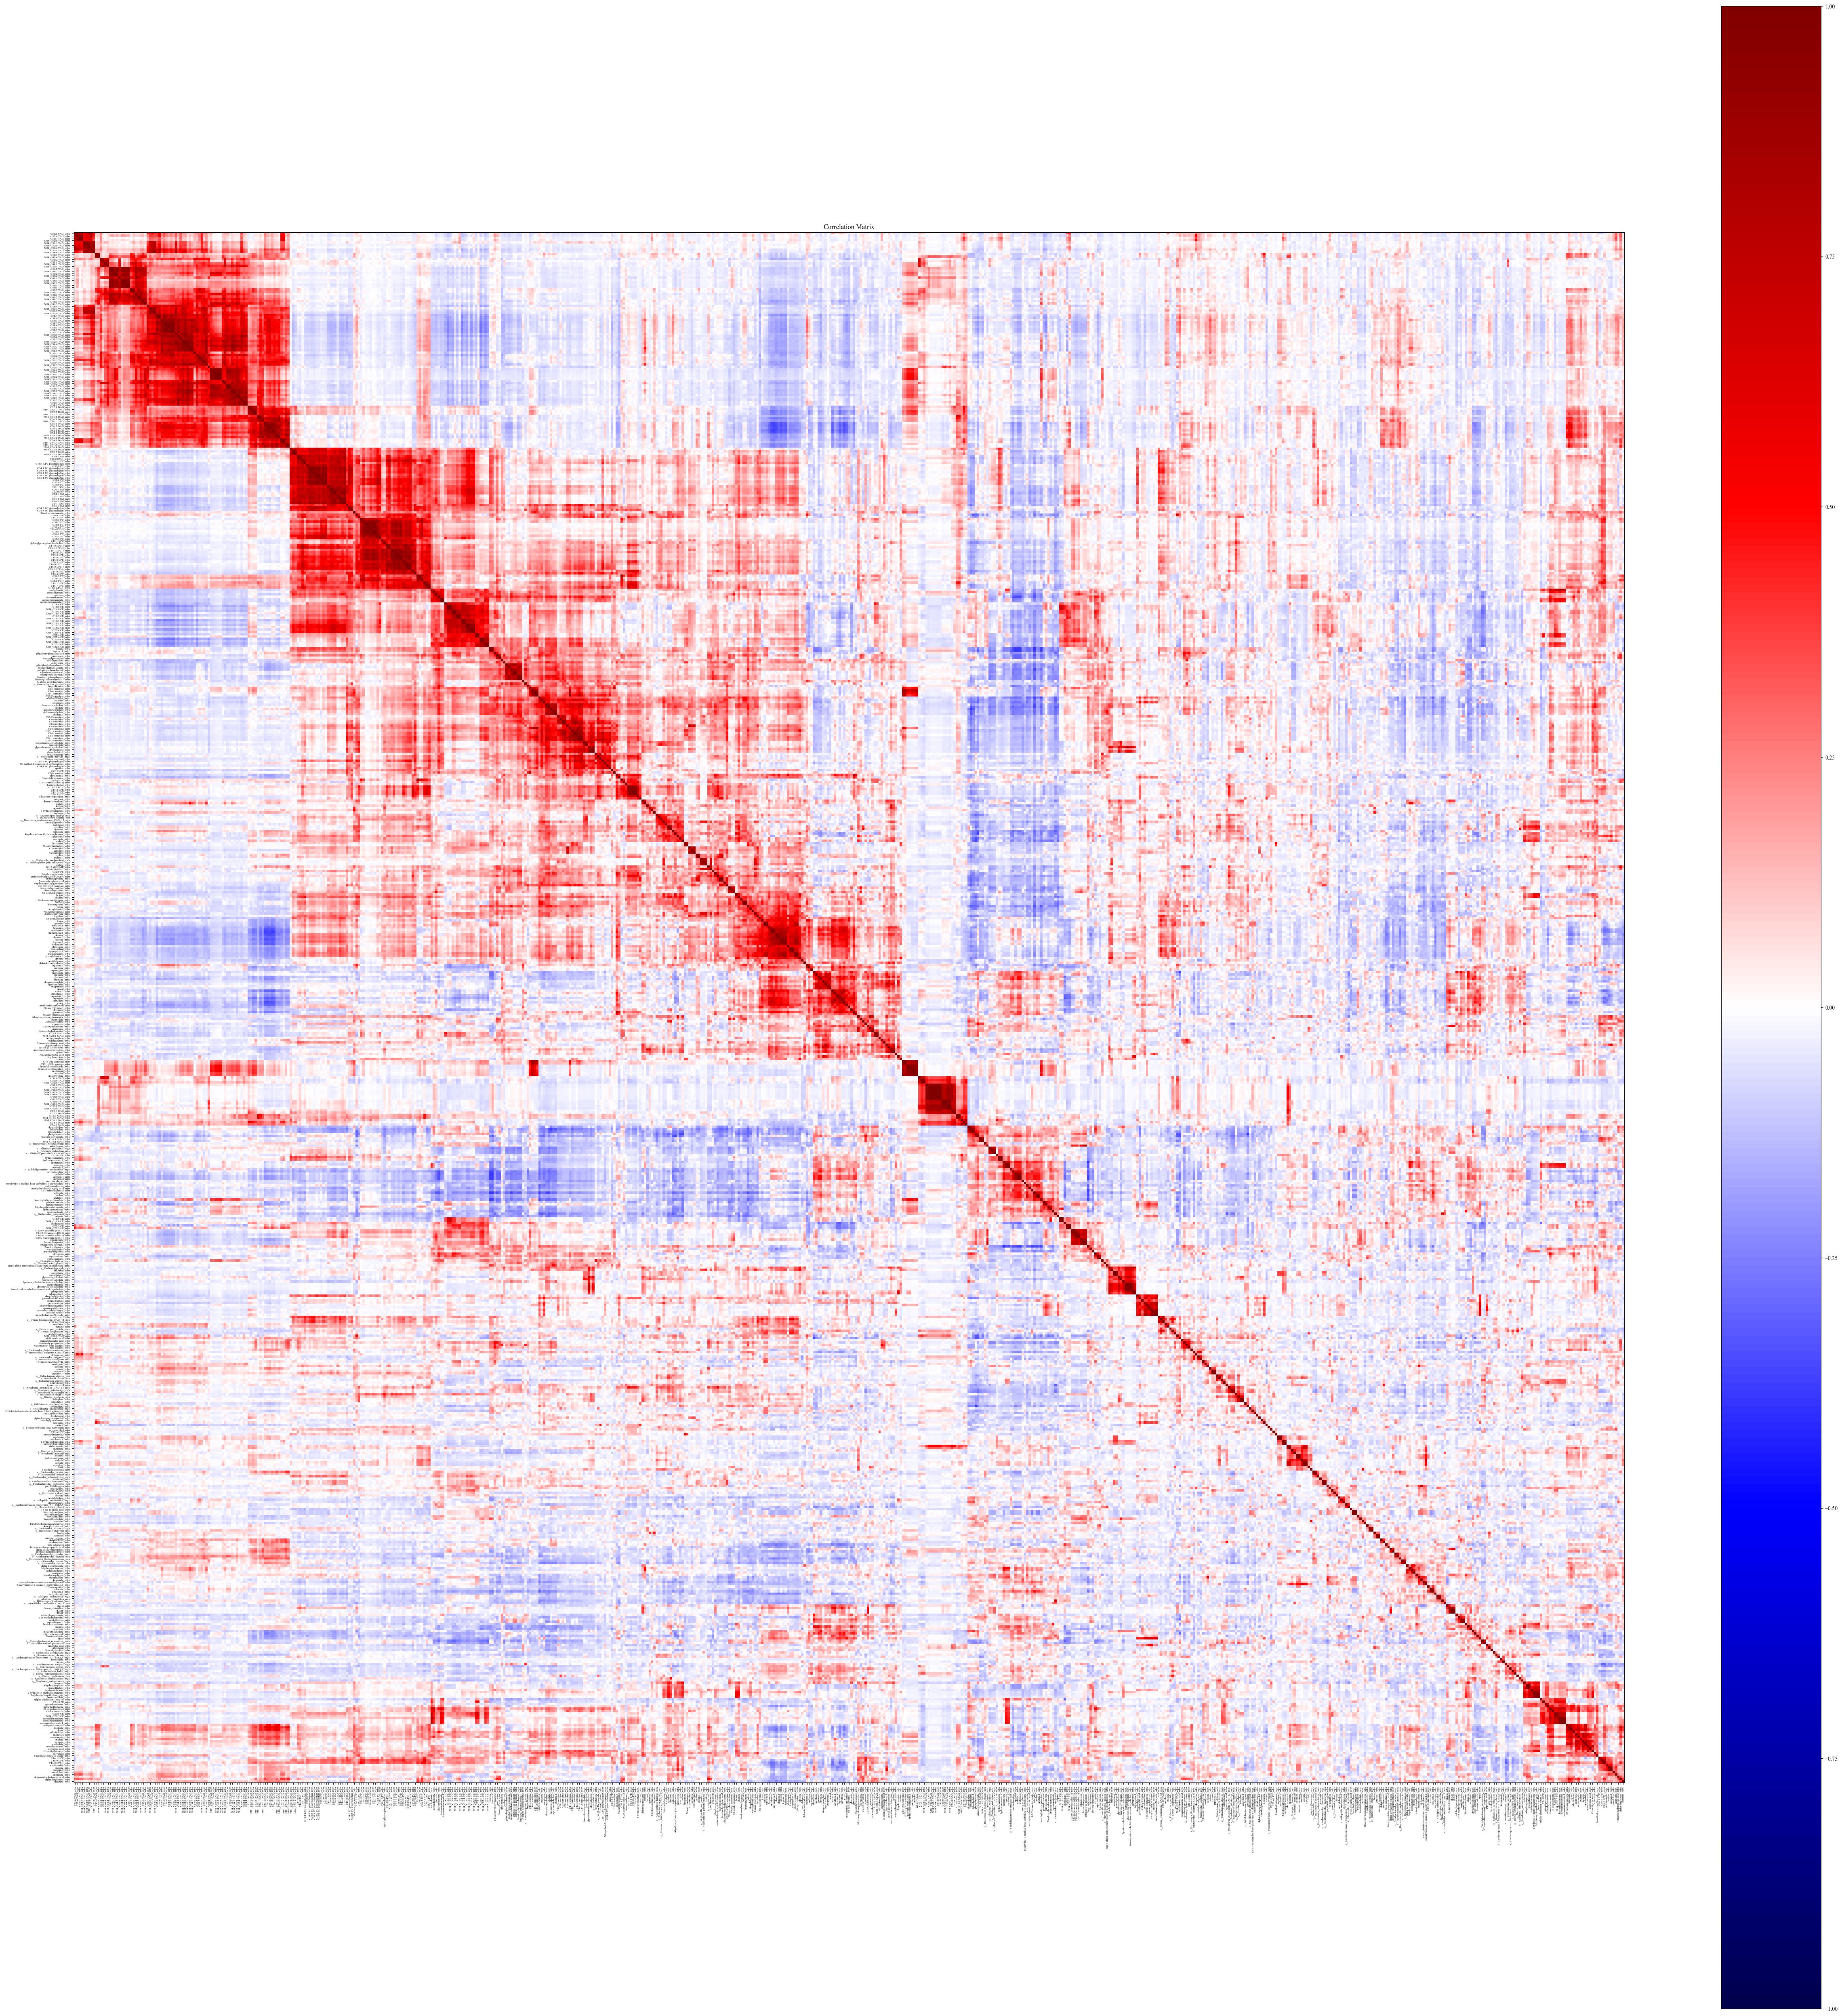

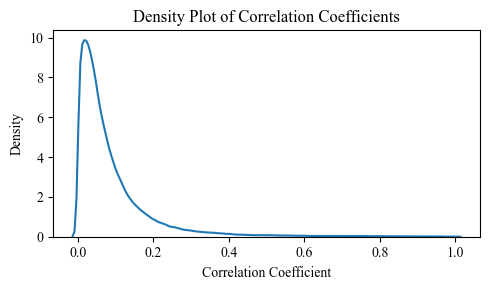

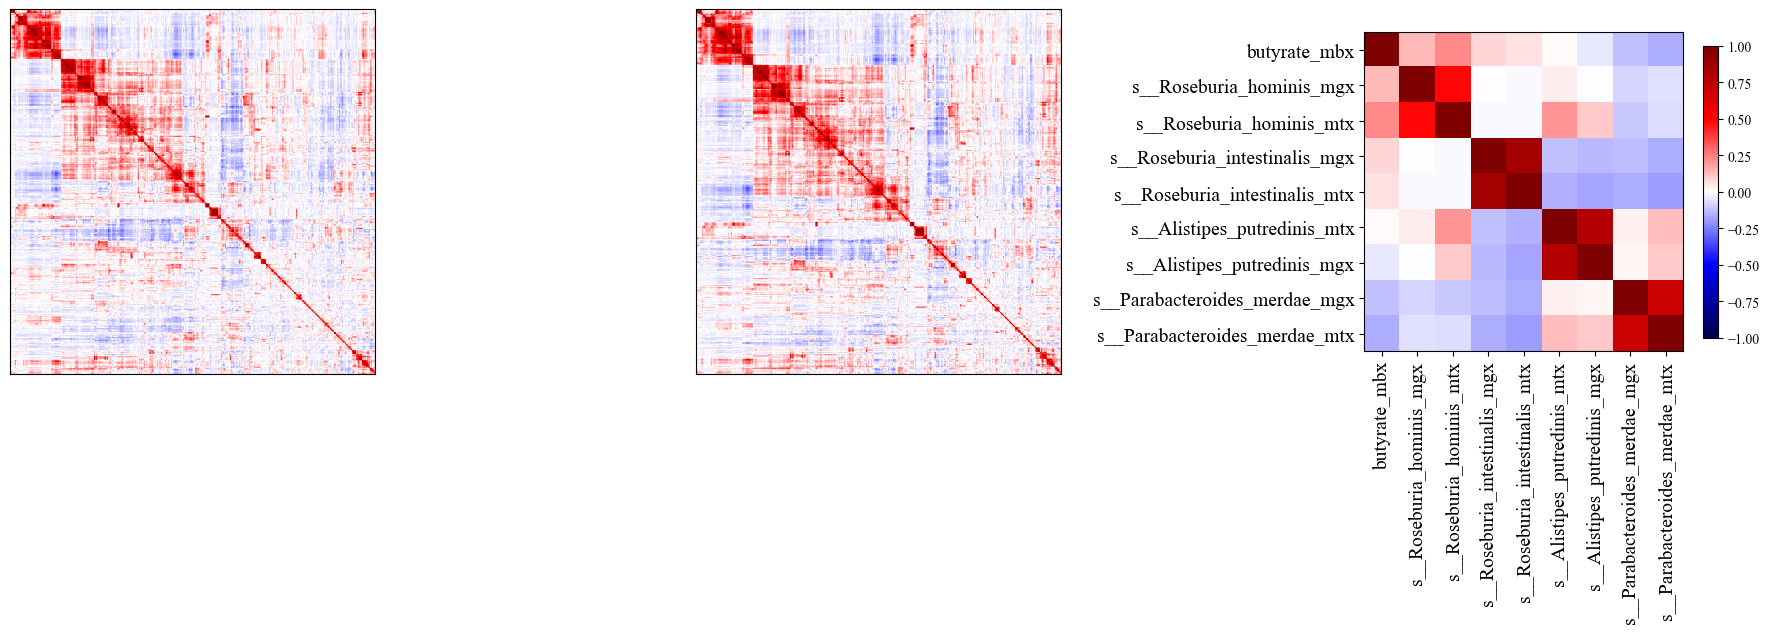

In [ ]:
path = Path("./ibdmdb_data/")
savepath = Path("./results_ibdmdb/")

# Read and merge dataframes
mgx_df = pd.read_csv(path / "aligned_mgx.tsv", sep="\t")
mtx_df = pd.read_csv(path / "aligned_mtx.tsv", sep="\t")
mbx_df = pd.read_csv(path / "aligned_mbx.tsv", sep="\t")

# Store original mbx columns (excluding ID)
mbx_original_columns = [col for col in mbx_df.columns if col != "ID"]

# Add suffixes to all non-ID columns
mgx_df = mgx_df.rename(
    columns={col: f"{col}_mgx" for col in mgx_df.columns if col != "ID"}
)
mtx_df = mtx_df.rename(
    columns={col: f"{col}_mtx" for col in mtx_df.columns if col != "ID"}
)
mbx_df = mbx_df.rename(
    columns={col: f"{col}_mbx" for col in mbx_df.columns if col != "ID"}
)

df = mgx_df.merge(mtx_df, on="ID").merge(mbx_df, on="ID").set_index("ID")

# Calculate correlation matrix with hierarchical clustering order
corr_matrix = df.corr()
columns = corr_matrix.columns
linkage_matrix = linkage(corr_matrix, method="average")
ordered_indices = leaves_list(linkage_matrix)
corr_matrix = corr_matrix.iloc[ordered_indices, ordered_indices]
columns = columns[ordered_indices]

# Large heatmap
STEP = 1
fig = plt.figure(figsize=(50, 50))
plt.imshow(corr_matrix, cmap="seismic", vmin=-1, vmax=1)
plt.xticks(np.arange(0, len(columns), STEP), columns[::STEP], rotation=90, fontsize=5)
plt.yticks(np.arange(0, len(columns), STEP), columns[::STEP], fontsize=5)
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
fig.savefig(savepath / "Correlation_matrix.png", dpi=200)

# Distribution plot
upper_triangle_indices = np.triu_indices_from(corr_matrix, k=1)
upper_triangle_values = corr_matrix.values[upper_triangle_indices]
fig = plt.figure(figsize=(5, 3))
sns.kdeplot(abs(upper_triangle_values), bw_adjust=0.5)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Density")
plt.title("Density Plot of Correlation Coefficients")
plt.tight_layout()
fig.savefig(savepath / "Correlation_distribution.png", dpi=200)

# Three-panel subplot
specific_columns = [
    "butyrate_mbx",
    "s__Roseburia_hominis_mgx",
    "s__Roseburia_hominis_mtx",
    "s__Roseburia_intestinalis_mgx",
    "s__Roseburia_intestinalis_mtx",
    "s__Alistipes_putredinis_mtx",
    "s__Alistipes_putredinis_mgx",
    "s__Parabacteroides_merdae_mgx",
    "s__Parabacteroides_merdae_mtx",
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot A: Overall correlation matrix
im1 = axes[0].imshow(corr_matrix, cmap="seismic", vmin=-1, vmax=1)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Subplot B: Metabolites only (mbx) - with _mbx suffix
mbx_columns = [col for col in columns if "_mbx" in col]
mbx_corr = corr_matrix.loc[mbx_columns, mbx_columns]
im2 = axes[1].imshow(mbx_corr, cmap="seismic", vmin=-1, vmax=1)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Subplot C: Specified columns with labels
valid_columns = [col for col in specific_columns if col in columns]
if valid_columns:
    specific_corr = corr_matrix.loc[valid_columns, valid_columns]
    im3 = axes[2].imshow(specific_corr, cmap="seismic", vmin=-1, vmax=1)
    axes[2].set_xticks(range(len(valid_columns)))
    axes[2].set_yticks(range(len(valid_columns)))
    axes[2].set_xticklabels(valid_columns, rotation=90, fontsize=14)
    axes[2].set_yticklabels(valid_columns, fontsize=14)
else:
    axes[2].text(
        0.5,
        0.5,
        "No valid\ncolumns found",
        ha="center",
        va="center",
        transform=axes[2].transAxes,
    )

# Position colorbar to the right of subplot C
fig.colorbar(im1, ax=axes[2], shrink=0.8)
plt.tight_layout()
fig.savefig(
    savepath / "Correlation_matrix_three_panels.png", dpi=200, bbox_inches="tight"
)
plt.show()

### Running MOVE:

Since this is the main biological dataset, we will explore a bit more in detail what can be done with MOVE. 

In [ ]:
from move.data import io
from move.tasks import encode_data
# Run move on ibdmdb data:
from omegaconf import OmegaConf

config = io.read_config("ibdmdb", None)
# Print data config file
print(OmegaConf.to_yaml(config, resolve=True))

# Encode data
encode_data(config.data)

path = Path(config.data.interim_data_path)
cat_datasets, cat_names, con_datasets, con_names = io.load_preprocessed_data(
    path, config.data.categorical_names, config.data.continuous_names
)
dataset_names = config.data.categorical_names + config.data.continuous_names

# Print shapes of the different datasets
for dataset, dataset_name in zip(cat_datasets + con_datasets, dataset_names):
    print(f"{dataset_name}: {dataset.shape}")

**Analyze the latent space:**

This step includes our self-implemented SHAP analysis. 

We will explore the hyperparameter space aiming to:
- Identify changes in the way MOVE distributes samples in latent space.
- Identify trends that might be shared regardless of the choice of hyperparameters.

We will modify:
- Number of latent nodes.
- Number of hidden nodes.
- Beta (KLD strength).
- Weight on the loss from continuous datasets.
    - Since equal weights leads to latent space fragmentation (i.e. categorical variables like dysbiosis or ibd status"win"), we can increase the importance of properly reconstructing the continuous features.

In [ ]:
# Analyze latent
#! move-dl task=ibdmdb__latent data=ibdmdb # Command line style

# Analyze latent
results_path = "./results_ibdmdb/results_temp/"
Path(results_path).mkdir(exist_ok=True, parents=True)
hyper_list = [
    (lat, hid, bet, w)
    for bet in [0.01, 0.0001]
    for hid in [[64], [256], [512]]
    for lat in [16, 32]
    for w in [1, 2]
]

# Loop over hyperparameters:
for i, (lat, hid, bet, w) in enumerate(hyper_list):
    foldername = f"latent_{lat}_{hid}_{bet}_{w}"
    if foldername not in os.listdir(results_path):
        os.mkdir(results_path + foldername)

        # Remove model file if it exists
        model_path = "./results_ibdmdb/latent_space/model.pt"
        if os.path.exists(model_path):
            os.remove(model_path)

        # Train the model
        cmd = f'move-dl data=ibdmdb task=ibdmdb__latent task.model.beta={bet} task.model.num_latent={lat} "task.model.num_hidden={hid}" data.continuous_inputs.0.weight={w} data.continuous_inputs.1.weight={w} data.continuous_inputs.2.weight={w}'
        ! {cmd}

        # Copy results
        ! cp -r results_ibdmdb/latent_space/ "{results_path}{foldername}"
        print(f"Finished {foldername}")
    else:
        print(f"{foldername} was already created")

In [ ]:
# Visualize rankings:
path = Path("./results_ibdmdb/results_temp/")
savepath = Path("./results_ibdmdb/")

ls = "latent_space"

datasets = ["mgx", "mtx", "mbx"]

for folder in os.listdir(path):
    print(folder)
    _, lat, hid, beta, w = folder.split("_")
    for dataset in datasets:
        df = pd.read_csv(
            f"./results_ibdmdb/results_temp/latent_{lat}_{hid}_{beta}_{w}/feat_importance_aligned_{dataset}.tsv",
            sep="\t",
        ).set_index("sample")
        # Order
        top10_ids = np.argsort(np.sum(np.abs(df.values), axis=0))[
            ::-1
        ]  # [:10] to trully get the first 10 in each hyperparam set
        order = np.take(df.columns, top10_ids)
        with open(savepath / f"SHAP_{dataset}.txt", "a") as f:
            for o, feature in enumerate(order):
                f.write(f"{o}\t{feature}\n")

In [ ]:
# Visualize rankings:
for dataset in datasets:
    colnames = ["Rank", "feature"]

    df = pd.read_csv(savepath / f"SHAP_{dataset}.txt", sep="\t", names=colnames)
    df_violin = pd.DataFrame()
    df_violin["Lists"] = df.groupby("feature")["Rank"].apply(list)
    df_violin["median"] = [np.median(l) for l in df_violin["Lists"]]
    df_violin = df_violin.sort_values(by="median")

    fig = plt.figure(figsize=(8, 4))
    parts = plt.violinplot(df_violin["Lists"], showmedians=True, showextrema=False)

    for pc in parts["bodies"]:
        pc.set_facecolor("#c9dbeb")
        pc.set_alpha(1)

    # Customize median points
    median_line = parts["cmedians"]
    median_line.set_linewidth(0)  # Hide the line
    scatter_x = range(1, len(df_violin["Lists"]) + 1)
    scatter_y = [np.median(subset) for subset in df_violin["Lists"]]

    plt.scatter(scatter_x, scatter_y, color="black", marker="D", s=5, zorder=3)
    plt.xticks(
        np.arange(1, len(df_violin["Lists"]) + 1), labels=df_violin.index, rotation=90
    )
    plt.ylabel("Rank")
    plt.tight_layout()
    fig.savefig(savepath / f"{dataset}_SHAP.png", dpi=200)

In [ ]:
# Tune reconstructions
! move-dl experiment=ibdmdb__tune_reconstruction

In [ ]:
results = pd.read_csv("./results_ibdmdb/tune_model/reconstruction_stats.tsv", sep="\t")
results.head(4)

In [ ]:
savepath = Path("./results_ibdmdb/tune_model/")

fig = plt.figure(layout="constrained", figsize=(20, 8))
subfigs = fig.subfigures(2, 1)

batch_sizes = [16, 32]
num_hidden = [[256], [512]]
num_latent = [8, 32, 64]

# Colors:
batch_colors = {"train": ["#7570b3", "#4c4982"], "test": ["#1b9e77", "#0f6b4f"]}

for i in range(len(num_hidden)):
    subfigs[i].suptitle(f"Hidden: {num_hidden[i]}")

    subset_results = results.query(f"`task.model.num_hidden` == '{num_hidden[i]}'")

    datasets = [
        "aligned_mbx",
        "aligned_mgx",
        "aligned_mtx",
        "aligned_ibd",
        "aligned_dysbiosis",
    ]
    titles = [
        "Metabolomics",
        "Metagenomics",
        "Metatranscriptomics",
        "IBD status",
        "Dysbiosis",
    ]

    axes = subfigs[i].subplots(1, 5)

    legend_handles_all = []  # Store handles for legend

    for j, (dataset, title) in enumerate(zip(datasets, titles)):
        dataset_results = subset_results.query(f"dataset == '{dataset}'")

        for batch_idx, batch_size in enumerate(batch_sizes):
            batch_results = dataset_results.query(f"`task.batch_size` == {batch_size}")

            train_stats = []
            test_stats = []

            for latent in num_latent:
                train_data = batch_results.query(
                    f"split == 'train' and `task.model.num_latent` == {latent}"
                )
                test_data = batch_results.query(
                    f"split == 'test' and `task.model.num_latent` == {latent}"
                )

                if len(train_data) > 0:
                    train_stats.append(train_data.to_dict(orient="records")[0])
                    train_stats[-1]["fliers"] = []

                if len(test_data) > 0:
                    test_stats.append(test_data.to_dict(orient="records")[0])
                    test_stats[-1]["fliers"] = []

            n_fields = len(train_stats)
            offset = batch_idx * 0.2 - 0.1
            positions_train = [x + offset for x in range(0, n_fields * 2, 2)]
            positions_test = [x + offset for x in range(1, n_fields * 2, 2)]

            if train_stats:
                coll1 = axes[j].bxp(
                    train_stats,
                    positions=positions_train,
                    widths=0.15,
                    boxprops=dict(facecolor=batch_colors["train"][batch_idx]),
                    patch_artist=True,
                )
                if j == 0:  # Only collect from first dataset
                    legend_handles_all.append(coll1["boxes"][0])

            if test_stats:
                coll2 = axes[j].bxp(
                    test_stats,
                    positions=positions_test,
                    widths=0.15,
                    boxprops=dict(facecolor=batch_colors["test"][batch_idx]),
                    patch_artist=True,
                )
                if j == 0:  # Only collect from first dataset
                    legend_handles_all.append(coll2["boxes"][0])

        axes[j].set(
            xticks=np.arange(0.5, n_fields * 2, 2),
            xticklabels=num_latent[:n_fields],
            ylim=(0, 1),
            xlabel="# latent dimensions",
            title=title,
        )

        if j == 0:
            axes[j].set_ylabel("Reconstruction accuracy")
        else:
            axes[j].set_yticklabels([])

        if i == 0:
            axes[j].set_xlabel("")

    # Add legend to last subplot of bottom row
    if i == 1 and legend_handles_all:
        legend_labels = [
            f"train (bs={batch_sizes[0]})",
            f"test (bs={batch_sizes[0]})",
            f"train (bs={batch_sizes[1]})",
            f"test (bs={batch_sizes[1]})",
        ]
        axes[-1].legend(
            legend_handles_all,
            legend_labels,
            title="split & batch size",
            fontsize="small",
        )

fig.savefig(savepath / "Tunning_reconstructions.png", dpi=200)

**Identify associations**

Here we will identify associations between Dysbiosis (cat), Metagenomics and Metatranscriptomics (cont) and the other continuous variables. We will use both KS and Bayes methods for the continuous, and the associations will be calculated when setting the weights on all continuous data modalities to 1 or 2. These hyperparams will be overwritten on the fly using hydra's functionalities.


In [ ]:
# Unified identification associations analysis
results_path = "./results_ibdmdb/results_temp_id_assoc/"
Path(results_path).mkdir(exist_ok=True, parents=True)

# Configuration
target_ds_list = [
    ("aligned_mgx", "plus_std"),
    ("aligned_mtx", "plus_std"),
    ("aligned_dysbiosis", 1),
]
NUM_EPOCHS = 400
N_REFITS = 24
BAYES_SIG_THR = 0.1
hyper_list = [(lat, hid, bet) for bet in [0.0001] for hid in [[256]] for lat in [32]]
w_values = [1, 2]

for w in w_values:
    print(f"=== Processing weight {w} ===")

    for i, (lat, hid, bet) in enumerate(hyper_list):
        hid_flat = hid[0]  # Extract 500 from [500]

        # Run Bayes with N_REFITS for all targets
        for TARGET_DS, TARGET_VALUE in target_ds_list:
            ds_results_path = f"{results_path}{TARGET_DS}_bayes_w{w}/"
            ! mkdir -p {ds_results_path}

            foldername = f"id_assoc_{lat}_{hid_flat}_{bet}_{TARGET_DS}_bayes_w{w}"

            if foldername not in os.listdir(ds_results_path):
                ! mkdir -p {ds_results_path}{foldername}
                print(f"Starting Bayes {foldername}")

                cmd = f'move-dl data=ibdmdb task=ibdmdb__id_assoc_bayes task.model.beta={bet} task.model.num_latent={lat} "task.model.num_hidden={hid}" task.target_dataset={TARGET_DS} task.num_refits={N_REFITS} task.target_value={TARGET_VALUE} task.sig_threshold={BAYES_SIG_THR} task.training_loop.num_epochs={NUM_EPOCHS} data.continuous_inputs.0.weight={w} data.continuous_inputs.1.weight={w} data.continuous_inputs.2.weight={w}'
                ! {cmd}

                ! cp -r results_ibdmdb/identify_associations/ "{ds_results_path}{foldername}"
                print(f"Finished Bayes {foldername}")
            else:
                print(f"Bayes {foldername} already exists")

        # Store models after Bayes training
        models_backup_path = f"./all_models/models_{lat}_{hid_flat}_{bet}_w{w}/"
        ! mkdir -p {models_backup_path}
        ! cp -r interim_data_ibdmdb/models {models_backup_path}

        # Run KS N_REFITS times (only for continuous targets)
        for run_idx in range(N_REFITS):
            # Reset models directory and load single model
            ! rm -rf interim_data_ibdmdb/models
            ! mkdir -p interim_data_ibdmdb/models
            ! cp "{models_backup_path}models/model_{lat}_{run_idx}.pt" interim_data_ibdmdb/models/model_{lat}_0.pt

            for TARGET_DS, TARGET_VALUE in target_ds_list:
                # Skip categorical targets for KS
                if TARGET_VALUE == 1:
                    continue

                ds_results_path = f"{results_path}{TARGET_DS}_ks_w{w}/"
                ! mkdir -p {ds_results_path}

                foldername = (
                    f"id_assoc_{lat}_{hid_flat}_{bet}_{TARGET_DS}_ks_{run_idx}_w{w}"
                )

                if foldername not in os.listdir(ds_results_path):
                    ! mkdir -p {ds_results_path}{foldername}
                    print(f"Starting KS {foldername}")

                    cmd = f'move-dl data=ibdmdb task=ibdmdb__id_assoc_ks task.model.beta={bet} task.model.num_latent={lat} "task.model.num_hidden={hid}" task.target_dataset={TARGET_DS} task.num_refits=1 task.target_value={TARGET_VALUE} task.sig_threshold=0.999 task.training_loop.num_epochs={NUM_EPOCHS} data.continuous_inputs.0.weight={w} data.continuous_inputs.1.weight={w} data.continuous_inputs.2.weight={w}'
                    ! {cmd}

                    ! cp -r results_ibdmdb/identify_associations/ "{ds_results_path}{foldername}"
                    print(f"Finished KS {foldername}")
                else:
                    print(f"KS {foldername} already exists")

print("All analyses completed!")

In [ ]:
# Train the model
cmd = f'move-dl data=ibdmdb task=ibdmdb__latent task.model.beta=0.0001 task.model.num_latent=16 "task.model.num_hidden=[64]" data.continuous_inputs.0.weight=1 data.continuous_inputs.1.weight=1 data.continuous_inputs.2.weight=1'
! {cmd}

In [ ]:
# Configuration
target_ds_list = [
    ("aligned_mgx", "plus_std"),
    ("aligned_mtx", "plus_std"),
    ("aligned_dysbiosis", 1),
]
NUM_EPOCHS = 400
N_REFITS = 24
BAYES_SIG_THR = 0.1
hyper_list = [(lat, hid, bet) for bet in [0.0001] for hid in [[256]] for lat in [32]]
w_values = [1, 2]

cmd = f'move-dl data=ibdmdb task=ibdmdb__id_assoc_bayes task.model.beta=0.0001 task.model.num_latent=32 "task.model.num_hidden=[256]" task.target_dataset=aligned_dysbiosis task.num_refits=24 task.target_value=1 task.sig_threshold={BAYES_SIG_THR} task.training_loop.num_epochs={NUM_EPOCHS} data.continuous_inputs.0.weight=2 data.continuous_inputs.1.weight=2 data.continuous_inputs.2.weight=2'
! {cmd}

In [ ]:
def ks_threshold(N, alpha):
    return np.sqrt(-(1 / N) * np.log(alpha / 2))


N_SAMPLES = 293
ALPHA = 0.05
KS_THR = ks_threshold(N_SAMPLES, ALPHA)
KS_THR = 0.075


def extract_folder_info(folder_name):
    """Extract dataset, method, weight, and run from folder names"""
    parts = folder_name.split("_")

    # Find weight (always last part starting with 'w')
    weight = parts[-1][1:]  # Remove 'w' prefix

    # Find method (bayes or ks)
    method_idx = None
    for i, part in enumerate(parts):
        if part in ["bayes", "ks"]:
            method_idx = i
            method = part
            break

    if method_idx is None:
        return None

    # Dataset is the part before method
    dataset = parts[method_idx - 1]

    # For ks, run is the part after method
    run = None
    if method == "ks" and method_idx + 1 < len(parts) - 1:
        run = parts[method_idx + 1]

    return {"dataset": dataset, "method": method, "weight": weight, "run": run}


def process_bayes_folders(results_dir):
    """Process all bayes folders and combine TSVs"""
    bayes_dfs = []

    for method_folder in os.listdir(results_dir):
        if "bayes" not in method_folder:
            continue

        method_path = os.path.join(results_dir, method_folder)
        if not os.path.isdir(method_path):
            continue

        for subfolder in os.listdir(method_path):
            subfolder_path = os.path.join(method_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            info = extract_folder_info(subfolder)
            if not info or info["method"] != "bayes" or info["dataset"] == "dysbiosis":
                continue

            tsv_file = os.path.join(subfolder_path, f"results_sig_assoc_bayes.tsv")
            if os.path.exists(tsv_file):
                df = pd.read_csv(tsv_file, sep="\t")
                df["Perturbing_dataset"] = info["dataset"]
                df["Continuous_weight"] = info["weight"]
                bayes_dfs.append(df)

    if bayes_dfs:
        return pd.concat(bayes_dfs, ignore_index=True)
    return None


def process_ks_folders(results_dir):
    """Process all ks folders and combine TSVs into single table"""
    ks_dfs = []

    for method_folder in os.listdir(results_dir):
        if "ks" not in method_folder:
            continue

        method_path = os.path.join(results_dir, method_folder)
        if not os.path.isdir(method_path):
            continue

        for subfolder in os.listdir(method_path):
            subfolder_path = os.path.join(method_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            info = extract_folder_info(subfolder)
            if not info or info["method"] != "ks" or info["dataset"] == "dysbiosis":
                continue

            tsv_file = os.path.join(subfolder_path, f"results_sig_assoc_ks.tsv")
            if os.path.exists(tsv_file):
                df = pd.read_csv(tsv_file, sep="\t")
                df["Perturbing_dataset"] = info["dataset"]
                df["Continuous_weight"] = info["weight"]
                df["Run"] = info["run"]
                ks_dfs.append(df)

    if ks_dfs:
        return pd.concat(ks_dfs, ignore_index=True)
    return None


# Main execution
results_dir = "./results_ibdmdb/results_temp_id_assoc"

# Process bayes folders
bayes_combined = process_bayes_folders(results_dir)
if bayes_combined is not None:
    bayes_combined.to_csv("combined_bayes_results.tsv", sep="\t", index=False)
    print(f"Bayes results saved: {len(bayes_combined)} rows")

# Process ks folders
ks_combined = process_ks_folders(results_dir)
if ks_combined is not None:
    # At the top with other variables
    ks_combined = ks_combined[ks_combined["ks_distance"] >= KS_THR].sort_values(
        "ks_distance", ascending=False
    )
    ks_combined.to_csv("combined_ks_results.tsv", sep="\t", index=False)
    print(f"KS results saved: {len(ks_combined)} rows")

print("Processing complete!")

In [ ]:
ks_sorted = ks_combined.sort_values("ks_distance", ascending=True)
ks_sorted[ks_sorted["feature_b_dataset"] == "aligned_mbx"].head(25)

## Miscellaneous: 

**KS threshold as a function of the number of samples and the alpha / p-value threshold we'd like to set:**

In [ ]:
# Function to compute KS threshold


def ks_threshold(N, alpha):
    return np.sqrt(-(1 / N) * np.log(alpha / 2))


# Define the range for N and alpha
N_values = np.linspace(100, 500, 10000)  # Avoid zero to prevent division by zero
alpha_values = np.linspace(0.001, 1, 1000)  # Avoid zero for alpha to prevent log(0)

# Create a meshgrid for N and alpha
N_grid, alpha_grid = np.meshgrid(N_values, alpha_values)
ks_thrs = ks_threshold(N_grid, alpha_grid)

# Create a 2D heatmap
fig, ax = plt.subplots(figsize=(7, 3.5))
c = ax.pcolormesh(N_grid, alpha_grid, ks_thrs, shading="auto", cmap="RdYlBu")

# Add a color bar
fig.colorbar(c, ax=ax, label="KS Threshold")

# Set labels
ax.set_xlabel("Number of Samples N")
ax.set_ylabel("Significance Threshold")
ax.set_title("Heatmap of KS Threshold")
# Set x-axis to logarithmic scale
# ax.set_xscale('log')
fig.tight_layout()
fig.savefig("KS_thr_heatmap.png", dpi=200)

**Bayes score trends:**

The Bayes score measured, at a cohort level, whether perturbing a feature A will shift the values of any other feature B up or down. The score is derived from the fraction of individuals or samples that recapitulate such behavior ($prob$). Here we plot the different scores as a function of the number of samples going up or down.

In [ ]:
prob = np.arange(0, 1.01, 0.01)
bayes_k = np.log(prob + 1e-8) - np.log(1 - prob + 1e-8)
bayes_abs = np.abs(bayes_k)
bayes_p = np.exp(bayes_abs) / (1 + np.exp(bayes_abs))

fig, axs = plt.subplots(3)
axs[0].plot(prob, prob)
axs[0].set_xlabel("prob")
axs[0].set_ylabel("prob")
axs[1].plot(prob, bayes_k)
axs[1].set_xlabel("prob")
axs[1].set_ylabel("bayes_k")
axs[2].plot(prob, bayes_p)
axs[2].set_xlabel("prob")
axs[2].set_ylabel("bayes_p")
fig.show()

**Residualization:**

This function can be used if we want to remove the linear contributions of a number of covariates to the data before feeding the data to MOVE. Please be careful not to log2 transform residualized data, which will contain negative values.

In [ ]:
def residualize(targets, covariates):
    """
    This function trains a linear model to take into account the contributions
    of age, sex and batch in the gene expression values (RNA counts).

    Args:
        targets: Pandas dataframe of shape (N_samples x N_target_features)
                 containing the target features to correct.
        covariates: Pandas dataframe of shape (N_samples x N_covariates)
                    containing the independent variables that we want to
                    correct for.
    Returns:
        corrected_targets: Array with the linear contributions of the covariates
                           removed.

    """
    import statsmodels.api as sm

    # Add a constant term to the independent variables
    covariates = sm.add_constant(covariates)

    # Fit a multivariate linear regression model
    model = sm.OLS(targets, covariates).fit()
    predictions = pd.DataFrame(data=model.predict(covariates))
    predictions.columns = targets.columns

    # Get the residuals (corrected values) for each target variable
    residuals = targets - predictions

    # Return the residuals (corrected targets)
    return residuals

**Checking the reconstructed class after perturbing a categorical variable:**

In [ ]:
a, b = np.load("cat_class_baseline.npy"), np.load("cat_recon_baseline.npy")
c, d = np.load("cat_class_perturb_0.npy"), np.load("cat_recon_perturb_0.npy")


df = pd.DataFrame(
    {
        "class_baseline": a[:, 1],
        "recon_baseline": b[:, 1],
        "class_perturb": c[:, 1],
        "recon_perturb": d[:, 1],
    }
)
df.to_csv("Baseline_vs_reconstructed_Bayes_dysbiosis.tsv", sep="\t")